In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

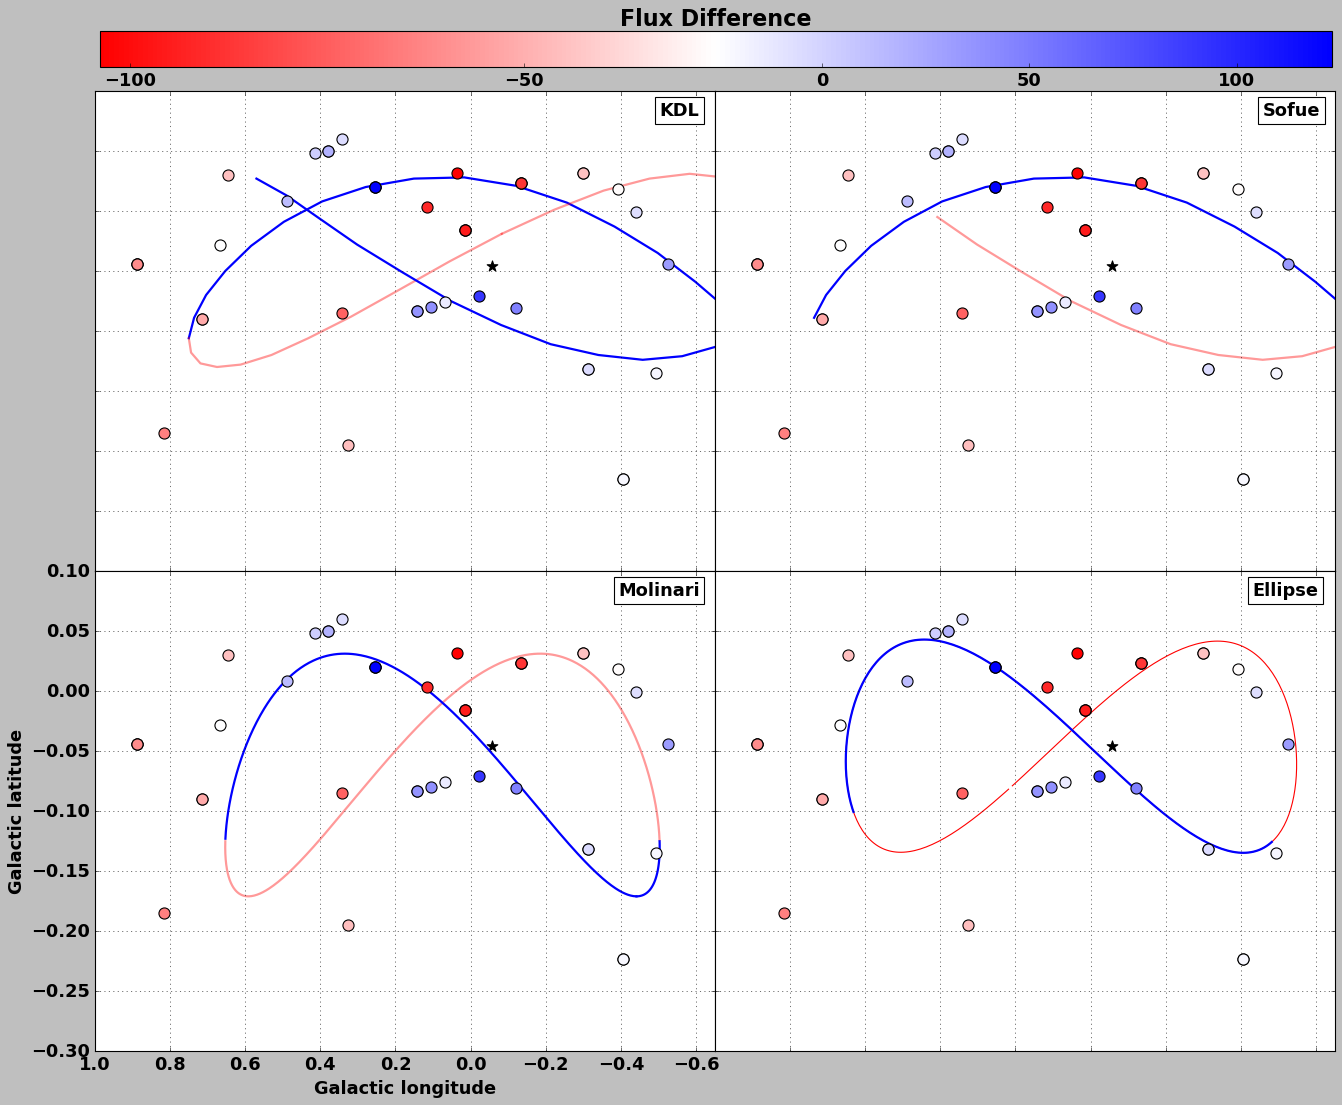

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table
import matplotlib.pyplot as pl
import matplotlib.colors as mc
from scipy.interpolate import NearestNDInterpolator
from numpy import linspace, array, logspace, sin, cos, pi, arange, sqrt, arctan2, arccos
from mpl_toolkits.mplot3d import Axes3D
from coords import *
from adjustText import adjust_text
import matplotlib.patheffects as PathEffects
from astropy.coordinates import Angle
import astropy.units as u


plt.style.use('classic')
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.size"] = "16"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

def rotate(x,y,theta):
    xprime = x*cos(theta) - y*sin(theta)
    yprime = x*sin(theta) + y*cos(theta)
    return xprime, yprime

l_offset = np.radians(-0.0558)
b_offset = np.radians(-0.0462)
x_offset = Rsun*l_offset
y_offset = Rsun*b_offset

#############################
# create class that stores a ring
#############################

class Ring:

    def __init__(self,t,a,b,z,v0,theta,xyzsun,vxyzsun,alpha=0.4):
        self.t     = t
        self.a     = a
        self.b     = b
        self.z0    = z
        self.v0    = v0
        self.theta = theta
        self.x     = a*cos(t)
        self.y     = -b*sin(t)
        self.z     = self.z0*sin(-2*t + alpha)
        self.R     = sqrt(self.x**2+self.y**2)
        self.phi   = -arctan2(self.y,self.x)
        self.ephix = -sin(self.phi) # unit vector parallel to circle
        self.ephiy = -cos(self.phi) # unit vector parallel to circle
        norm       = sqrt((a*sin(t))**2+(b*cos(t))**2)
        self.ex    = -a*sin(t)/norm # unit vector parellel to ellipse
        self.ey    = -b*cos(t)/norm  # unit vector parallel to ellipse
        self.cosalpha = self.ex*self.ephix + self.ey*self.ephiy
        self.vphi  = self.R[0]*self.v0/self.R # assume conservation of angular momentum
        self.v     = self.vphi/self.cosalpha # total speed along the orbit
        self.vx    = +self.v*self.ex
        self.vy    = +self.v*self.ey
        self.vz    = np.zeros(t.size)
        self.x,self.y   = rotate(self.x,self.y,theta)
        self.vx,self.vy = rotate(self.vx,self.vy,theta)
        self.X,self.Y,self.Z,self.vX,self.Vy,self.vZ = xyz2XYZ(self.x,self.y,self.z,self.vx,self.vy,self.vz,xyzsun[0],xyzsun[1],xyzsun[2],vxyzsun[0],vxyzsun[1],vxyzsun[2])
        # Convert Sgr A* offset from degrees to radians
        l_offset = np.radians(0.05)
        b_offset = np.radians(-0.0462)
        x_offset = Rsun*l_offset
        y_offset = 0
        z_offset = Rsun*b_offset
        # Calculate galactic coordinates accounting for Sgr A* offset
        self.l,self.b,self.r,self.vl,self.vb,self.vr = xyz2lbr(
            self.x,self.y,self.z,self.vx,self.vy,self.vz,
            xyzsun[0],xyzsun[1],xyzsun[2],vxyzsun[0],vxyzsun[1],vxyzsun[2])
        self.l += l_offset
        self.b += b_offset
        self.x += x_offset
        self.y += y_offset
        self.z += z_offset
        self.mu_l, self.mu_b = vlb_2_mulb(self.r, self.vl*100, self.vb*100)
        self.mu_l, self.mu_b = vlb_2_mulb(self.r,self.vl*100,self.vb*100)


#############################
# define sun position & velocity
#############################

xsun  = 0.0
ysun  = -8.1
zsun  = 0.0
vxsun = -2.2
vysun = 0.0
vzsun = 0.0
xyzsun  = [xsun, ysun, zsun ]
vxyzsun = [vxsun,vysun,vzsun]
phisun  = arctan2(ysun,xsun)

#############################
# define rings
#############################

a_rings = 0.09 # x axis of the rings in kpc
b_rings = 0.055 # y axis of the rings in kpc
z_rings = 0.0125 # height of the ring above/below plane in kpc
v_rings = 130.0 # tangential velocity at initial point
theta_rings = np.radians(25) # inclination of the rings
dphi = np.radians(1)
phi  = arange(phisun+dphi/2,phisun+2*pi,dphi)
Rings = Ring(phi,a_rings,b_rings,z_rings,v_rings,theta_rings,xyzsun,vxyzsun)

back_ind = np.where(Rings.y>=y_offset)
fore_ind = np.where(Rings.y<=y_offset)

scouse_fits = pd.read_csv('final_cmz_scouse_hnco_fits.csv',
              usecols=[0,1,2,3,5,7], names=['n', 'l', 'b', 'amp', 'velocity', 'FWHM'],
              sep="\s+")

cat = pd.read_csv('CMZ_cloud_catalogue_data.csv')

absorp_tab = Table.read('absorption_comparison_table_Oct22.tex')
absorp_value = absorp_tab['fraction_value']
absorp_13co = absorp_tab['co_h2co_ratio']
absorp_index = absorp_tab['leaf_id']

flux_frac_tab = Table.read('../paper_figs/Tables/CMZ_cat_flux_method_vals.tex')
flux_frac_value = flux_frac_tab['Extinction Fraction']
flux_frac_index = flux_frac_tab['leaf id']
flux_diff = flux_frac_tab['Flux Difference'] 
flux_ratio_fore = flux_frac_tab['Flux Ratio']
min_flux = flux_frac_tab['Min Flux'] #Min flux from RAW spitzer image


divnorm = mc.TwoSlopeNorm(vmin=flux_diff.min(), vcenter=np.median(flux_diff), vmax=flux_diff.max())

l   = scouse_fits['l'].values
b   = scouse_fits['b'].values
v   = scouse_fits['velocity'].values
amp = scouse_fits['amp'].values

fig, ax = plt.subplots(nrows=2, ncols=2,  figsize=(20,15))
plt.subplots_adjust(wspace=0, hspace=0)

for column in ax:
    for row in column:
        for i in range(0,len(cat)):
            if cat['index'][i] in flux_frac_index:
                sc = row.scatter(cat['l'][i], cat['b'][i], marker='o', s=100, edgecolor='k', zorder=3, c=flux_diff[flux_frac_index == cat['index'][i]], cmap='bwr_r', norm=divnorm)
            else:
                row.scatter(cat['l'][i], cat['b'][i], marker='*', s=150, edgecolor='k', zorder=3, c='k')     

        row.grid(True)
        row.set_xlim(1,-0.65)
        row.set_ylim(-0.3,0.1)
        row.set_rasterized(True)

"""
KDL
"""
kdl = np.loadtxt('kdl_lbv.txt', unpack=True)
lk, bk, vk = kdl[0], kdl[1], kdl[2]
ax[0][0].plot(lk[0:16], bk[0:16], ls='-', color='blue', linewidth=2, zorder=2)
ax[0][0].plot(lk[15:26], bk[15:26], ls='-', color='red', linewidth=2, alpha=0.4)
ax[0][0].plot(lk[25:36], bk[25:36], ls='-', color='red', linewidth=2, alpha=0.4)
ax[0][0].plot(lk[35:51], bk[35:51], ls='-', color='blue', linewidth=2, zorder=2)
ax[0][0].xaxis.set_ticklabels([])
ax[0][0].yaxis.set_ticklabels([])
ax[0][0].text(0.943, 0.96,'KDL', ha='center', va='center', transform=ax[0][0].transAxes,
           bbox=dict(facecolor='white', edgecolor='k', alpha=1))

"""
Sofue
"""
sofue1 = np.loadtxt('sofue_lbv_arm1.txt', unpack=True)
sofue1_l, sofue1_b, sofue1_v = sofue1[0], sofue1[1], sofue1[2]
ax[0][1].plot(sofue1_l, sofue1_b, ls='-', color='blue', linewidth=2, zorder=2)

sofue2 = np.loadtxt('sofue_lbv_arm2.txt', unpack=True)
sofue2_l, sofue2_b, sofue2_v = sofue2[0], sofue2[1], sofue2[2]
ax[0][1].plot(sofue2_l, sofue2_b, ls='-', color='red', linewidth=2, alpha=0.4)
ax[0][1].xaxis.set_ticklabels([])
ax[0][1].yaxis.set_ticklabels([])
ax[0][1].text(0.93, 0.96,'Sofue', ha='center', va='center', transform=ax[0][1].transAxes,
           bbox=dict(facecolor='white', edgecolor='k', alpha=1))

"""
Molinari
"""
ml = np.loadtxt('molinari_lbvlos.txt', unpack=True)
lk, bk, vk = ml[0], ml[1], ml[2]
ax[1][0].plot(-1*lk[80:580], bk[80:580], ls='-', color='red', linewidth=2, alpha=0.4)
ax[1][0].plot(-1*lk[0:80], bk[0:80], ls='-', color='blue', linewidth=2, zorder=2)
ax[1][0].plot(-1*lk[581:], bk[581:], ls='-', color='blue', linewidth=2, zorder=2)
ax[1][0].text(0.91, 0.96,'Molinari', ha='center', va='center', transform=ax[1][0].transAxes,
           bbox=dict(facecolor='white', edgecolor='k', alpha=1))
ax[1][0].set_xlabel('Galactic longitude')
ax[1][0].set_ylabel('Galactic latitude')

"""
Rings
"""

ax[1][1].plot(np.degrees(Rings.l[back_ind[0:-1]]),np.degrees(Rings.b[back_ind[0:-1]]),c='red')
ax[1][1].plot(np.degrees(Rings.l[fore_ind[0:]]),np.degrees(Rings.b[fore_ind[0:]]),c='blue', linewidth=2, zorder=2)

ax[1][1].xaxis.set_ticklabels([])
ax[1][1].yaxis.set_ticklabels([])
ax[1][1].text(0.92, 0.96,'Ellipse', ha='center', va='center', transform=ax[1][1].transAxes,
           bbox=dict(facecolor='white', edgecolor='k', alpha=1))

cax = fig.add_axes([0.128, .92, 0.77, 0.03])
cb = plt.colorbar(sc, ax=ax.ravel().tolist(), orientation='horizontal', cax=cax)
cb.ax.set_title('Flux Difference', size=20, fontweight='bold', fontname='sans-serif')

ax[0][0].scatter(-0.056, -0.046, marker = "*", s=100, color='k')
ax[0][1].scatter(-0.056, -0.046, marker = "*", s=100, color='k')
ax[1][0].scatter(-0.056, -0.046, marker = "*", s=100, color='k')
ax[1][1].scatter(-0.056, -0.046, marker = "*", s=100, color='k')


plt.savefig('3d_models_lb_ellipse_colorbar_flux_diff_updated.pdf')


plt.show()

# CORRELATION COEFFICIENT

In [4]:
cat = Table.read('CMZ_cloud_catalogue_data.tex')

#find mean of a


cat_index = cat['index']
cat_v = cat['v']

r_p_mom0 = cat['r_p_mom0']
r_s_mom0 =cat['r_s_mom0']
r_p_max = cat['r_p_max']
r_s_max = cat['r_s_max']

corr_coeff_use = r_p_max 

#cat.pprint_all()

In [5]:
#cat_agg = cat.groupby['lb_pixel_mask'] ==  1

cat_group = cat.group_by('lb_pixel_mask')
cat_group_mask = cat_group.groups.keys['lb_pixel_mask'] == 1

cat_agg = cat_group.groups[cat_group_mask]



# COMBINED SUBPLOTS?

In [6]:
#cat.pprint_all()

#cat_tex.write("/Users/danilipman/Documents/Research/UConn/3D_CMZ/LBV_plots_stuff/CMZ_cloud_catalogue_data.tex", overwrite=True)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
/opt/anaconda3/lib/python3.9/site-packages/matplotlib/text.py:831: UserWarning: Warning: converting a masked element to nan.
  y = float(self.convert_yunits(self._y))
/opt/anaconda3/lib/python3.9/site-packages/matplotlib/text.py:691: UserWarning: Warning: converting a masked element to nan.
  posy = float(self.convert_yunits(self._y))
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
/opt/anaconda3/lib/python3.9/site-packages/matplotlib/text.py:831: UserWarning: Warning: converting a masked element to nan.
  y = float(self.convert_yunits(self._y))
/opt/anaconda3/lib/python3.9/site-packages/matplotlib/text.py:691: UserWarning

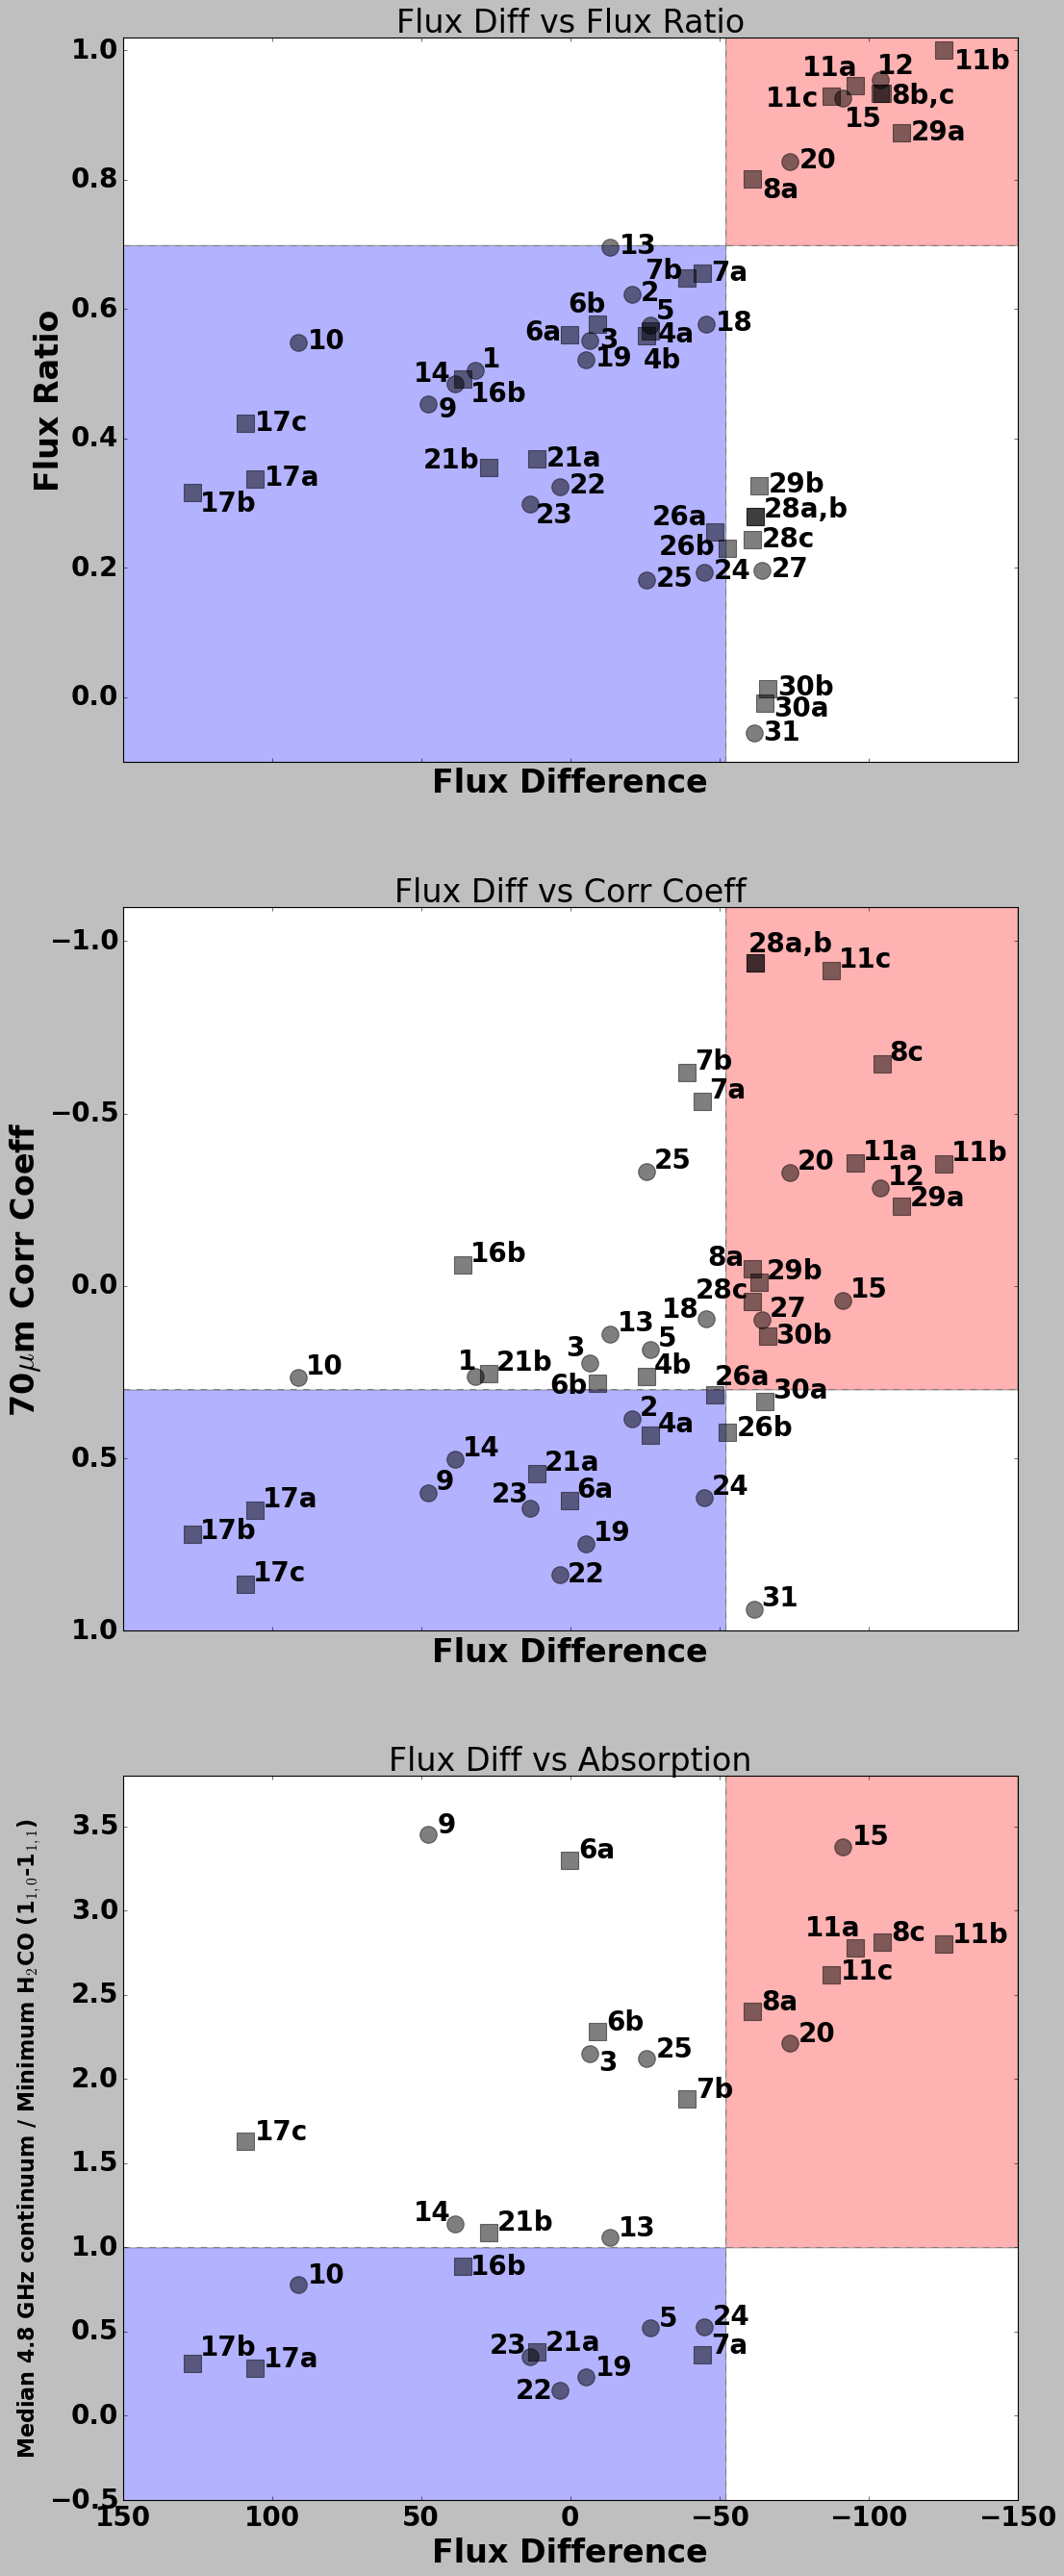

In [7]:
absorp_tab = Table.read('absorption_table_merged.tex')
absorp_value = absorp_tab['fraction_value_peak_mask']
absorp_index = absorp_tab['leaf_id']

plt.rcParams.update({'font.size': 25})
cat_tex= Table.read('CMZ_cloud_catalogue_data.tex') #table with the submasks labeled 

fore = 52.09
flux_ratio_center = 0.699

import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows = 3, figsize=(15,40), sharex=True)


text_list=[]
for i in range(0,len(cat_tex)):
    
    if cat_tex['index'][i][-1].isalpha():
        sc = ax[0].scatter(cat_tex['flux_diff_max'][i], cat_tex['flux_ratio_max'][i], marker='s', c='k', s=250, edgecolor='k', zorder=3, alpha=0.5)
        #ax[0].annotate(cat_tex['index'][i],(cat_tex['flux_diff_max'][i]-2.5, cat_tex['flux_ratio_max'][i] - 0.01))
        text_list.append(ax[0].text(cat_tex['flux_diff_max'][i]-3.1, cat_tex['flux_ratio_max'][i] - 0.01,cat_tex['index'][i]))

    else:
        sc = ax[0].scatter(cat_tex['flux_diff_max'][i], cat_tex['flux_ratio_max'][i], marker='o', c='k', s=250, edgecolor='k', zorder=3, alpha=0.5)
        #ax[0].annotate(cat_tex['index'][i],(cat_tex['flux_diff_max'][i]-2.5, cat_tex['flux_ratio_max'][i] - 0.01))
        text_list.append(ax[0].text(cat_tex['flux_diff_max'][i]-3.1, cat_tex['flux_ratio_max'][i] - 0.01, cat_tex['index'][i]))


###Reposition overlapping annotations###    
text_list[0].remove() #ID 1
text_list[0]=ax[0].text(cat_tex['flux_diff_max'][0]-2., cat_tex['flux_ratio_max'][0] + 0.005,cat_tex['index'][0])
text_list[13].remove() #ID 9
text_list[13]=ax[0].text(cat_tex['flux_diff_max'][13]-3.5, cat_tex['flux_ratio_max'][13] - 0.02,cat_tex['index'][13])
text_list[20].remove() #ID 14
text_list[20]=ax[0].text(cat_tex['flux_diff_max'][20]+14, cat_tex['flux_ratio_max'][20] + 0.005,cat_tex['index'][20])
text_list[23].remove() #ID 16b
text_list[23]=ax[0].text(cat_tex['flux_diff_max'][23]-2.5, cat_tex['flux_ratio_max'][23] - 0.035,cat_tex['index'][23])

text_list[6].remove() #ID 6a
text_list[6]=ax[0].text(cat_tex['flux_diff_max'][6]+15, cat_tex['flux_ratio_max'][6] - 0.008,cat_tex['index'][6])
text_list[7].remove() #ID 6b
text_list[7]=ax[0].text(cat_tex['flux_diff_max'][7]+10, cat_tex['flux_ratio_max'][7] + 0.02,cat_tex['index'][7])
text_list[9].remove() #ID 7b
text_list[9]=ax[0].text(cat_tex['flux_diff_max'][9]+14, cat_tex['flux_ratio_max'][9] ,cat_tex['index'][9])


text_list[5].remove() #ID 5
text_list[5]=ax[0].text(cat_tex['flux_diff_max'][5]-2, cat_tex['flux_ratio_max'][5] +0.01,cat_tex['index'][5])
text_list[3].remove() #ID 4a
text_list[3]=ax[0].text(cat_tex['flux_diff_max'][3]-2.5, cat_tex['flux_ratio_max'][3] -0.017,cat_tex['index'][3])
text_list[4].remove() #ID 4b
text_list[4]=ax[0].text(cat_tex['flux_diff_max'][4]+1, cat_tex['flux_ratio_max'][4] -0.05,cat_tex['index'][4])


text_list[31].remove() #ID 21b
text_list[31]=ax[0].text(cat_tex['flux_diff_max'][31]+22, cat_tex['flux_ratio_max'][31],cat_tex['index'][31])
text_list[33].remove() #ID 23
text_list[33]=ax[0].text(cat_tex['flux_diff_max'][33]-2, cat_tex['flux_ratio_max'][33]-0.03,cat_tex['index'][33])

text_list[36].remove() #ID 26a
text_list[36]=ax[0].text(cat_tex['flux_diff_max'][36]+21, cat_tex['flux_ratio_max'][36] + 0.01,cat_tex['index'][36])
text_list[37].remove() #ID 26b
text_list[37]=ax[0].text(cat_tex['flux_diff_max'][37]+23, cat_tex['flux_ratio_max'][37] - 0.01,cat_tex['index'][37])


text_list[39].remove() #ID 28a and b
text_list[40].remove()
text_list[39]=ax[0].text(cat_tex['flux_diff_max'][39]-2.8, cat_tex['flux_ratio_max'][39] , '28a,b')

text_list[11].remove() #ID 8b and c
text_list[12].remove() 
text_list[11]=ax[0].text(cat_tex['flux_diff_max'][11]-3.5, cat_tex['flux_ratio_max'][11] -0.015, '8b,c')
text_list[10].remove() #8a
text_list[10]=ax[0].text(cat_tex['flux_diff_max'][10]-3.1, cat_tex['flux_ratio_max'][10] -0.03, cat_tex['index'][10])


text_list[15].remove() #ID 11a
text_list[15]=ax[0].text(cat_tex['flux_diff_max'][15]+18, cat_tex['flux_ratio_max'][15] +0.015,cat_tex['index'][15])

text_list[16].remove() #ID 11b
text_list[16]=ax[0].text(cat_tex['flux_diff_max'][16]-3.5, cat_tex['flux_ratio_max'][16]-0.03,cat_tex['index'][16])

text_list[17].remove() #ID 11c
text_list[17]=ax[0].text(cat_tex['flux_diff_max'][17]+22, cat_tex['flux_ratio_max'][17] -0.015,cat_tex['index'][17])

text_list[18].remove() #ID 12
text_list[18]=ax[0].text(cat_tex['flux_diff_max'][18]+1, cat_tex['flux_ratio_max'][18] +0.01,cat_tex['index'][18])
text_list[21].remove() #ID 15
text_list[21]=ax[0].text(cat_tex['flux_diff_max'][21]-0.5, cat_tex['flux_ratio_max'][21] -0.045,cat_tex['index'][21])

text_list[44].remove() #ID 30a
text_list[44]=ax[0].text(cat_tex['flux_diff_max'][44]-3, cat_tex['flux_ratio_max'][44] -0.02,cat_tex['index'][44])

text_list[25].remove() #ID 17b
text_list[25]=ax[0].text(cat_tex['flux_diff_max'][25]-2.5, cat_tex['flux_ratio_max'][25] -0.03,cat_tex['index'][25])

    
text_list=[]
for i in range(0,len(cat_tex)):
    if cat_tex['index'][i][-1].isalpha():
        sc = ax[1].scatter(cat_tex['flux_diff_max'][i], cat_tex['r_p_max'][i], marker='s', c='k', s=250, edgecolor='k', zorder=3, alpha=0.5)
        #ax[1].annotate(cat_tex['index'][i],(cat_tex['flux_diff_max'][i]-2.5, cat_tex['r_p_max'][i] - 0.01))
        text_list.append(ax[1].text(cat_tex['flux_diff_max'][i]-2.5, cat_tex['r_p_max'][i] - 0.01, cat_tex['index'][i]))
    else:
        sc = ax[1].scatter(cat_tex['flux_diff_max'][i], cat_tex['r_p_max'][i], marker='o', c='k', s=250, edgecolor='k', zorder=3, alpha=0.5)
        #ax[1].annotate(cat_tex['index'][i],(cat_tex['flux_diff_max'][i]-2.5, cat_tex['r_p_max'][i] - 0.01))
        text_list.append(ax[1].text(cat_tex['flux_diff_max'][i]-2.5, cat_tex['r_p_max'][i] - 0.01, cat_tex['index'][i]))

    
    
    
text_list[0].remove() #ID 1
text_list[0]=ax[1].text(cat_tex['flux_diff_max'][0]+6, cat_tex['r_p_max'][0] -0.02, cat_tex['index'][0])   

text_list[2].remove() #ID 3
text_list[2]=ax[1].text(cat_tex['flux_diff_max'][2]+8, cat_tex['r_p_max'][2] -0.02, cat_tex['index'][2]) 
text_list[7].remove() #ID 6b
text_list[7]=ax[1].text(cat_tex['flux_diff_max'][7]+16, cat_tex['r_p_max'][7] +0.03, cat_tex['index'][7]) 

text_list[39].remove() #ID 28a and b
text_list[40].remove()
text_list[39]=ax[1].text(cat_tex['flux_diff_max'][39]+2.5, cat_tex['r_p_max'][39] -0.03, '28a,b')   
    
    
text_list[42].remove() #ID 29a
text_list[42]=ax[1].text(cat_tex['flux_diff_max'][42]-2.8, cat_tex['r_p_max'][42], cat_tex['index'][42])   

    
text_list[36].remove() #ID 26a
text_list[36]=ax[1].text(cat_tex['flux_diff_max'][36], cat_tex['r_p_max'][36]-0.03, cat_tex['index'][36])  
text_list[37].remove() #ID 26b
text_list[37]=ax[1].text(cat_tex['flux_diff_max'][37]-3, cat_tex['r_p_max'][37]+0.01, cat_tex['index'][37])  

text_list[10].remove() #ID 8a
text_list[10]=ax[1].text(cat_tex['flux_diff_max'][10]+15, cat_tex['r_p_max'][10]-0.01, cat_tex['index'][10])   
text_list[27].remove() #ID 18
text_list[27]=ax[1].text(cat_tex['flux_diff_max'][27]+15, cat_tex['r_p_max'][27]-0.005, cat_tex['index'][27]) 
text_list[41].remove() #ID 28c
text_list[41]=ax[1].text(cat_tex['flux_diff_max'][41]+19, cat_tex['r_p_max'][41]-0.01, cat_tex['index'][41])     
text_list[45].remove() #ID 30b
text_list[45]=ax[1].text(cat_tex['flux_diff_max'][45]-2.5, cat_tex['r_p_max'][45]+0.02,cat_tex['index'][45])
 
text_list[32].remove() #ID 22
text_list[32]=ax[1].text(cat_tex['flux_diff_max'][32]-2.5, cat_tex['r_p_max'][32]+0.02,cat_tex['index'][32])
text_list[33].remove() #ID 23
text_list[33]=ax[1].text(cat_tex['flux_diff_max'][33]+13, cat_tex['r_p_max'][33]-0.02,cat_tex['index'][33])

text_list[25].remove() #ID 17b
text_list[25]=ax[1].text(cat_tex['flux_diff_max'][25]-2.5, cat_tex['r_p_max'][25]+0.01,cat_tex['index'][25])

    
text_list=[]
match_index_list=[]
for i in range(0,len(absorp_index)):
        if absorp_index[i] in cat_tex['index']:
            match_index = np.where(cat_tex['index']==absorp_index[i])
            match_index_list.append(match_index[0][0])
            if absorp_index[i][-1].isalpha():

                sc = ax[2].scatter(cat_tex['flux_diff_max'][match_index][0],np.array(absorp_value)[i], marker='s', c='k', s=250, edgecolor='k', zorder=3, alpha=0.5)
                #text = ax[2].annotate(absorp_index[i],(cat_tex['flux_diff_max'][match_index][0]-3,absorp_value[i] + 0.01))
                text_list.append(ax[2].text(cat_tex['flux_diff_max'][match_index][0]-3, absorp_value[i] + 0.01, absorp_index[i]))
            else: 

                sc = ax[2].scatter(cat_tex['flux_diff_max'][match_index][0],absorp_value[i], marker='o', c='k', s=250, edgecolor='k', zorder=3, alpha=0.5)
                #text = ax[2].annotate(absorp_index[i],(cat_tex['flux_diff_max'][match_index][0]-3,absorp_value[i] + 0.01))
                text_list.append(ax[2].text(cat_tex['flux_diff_max'][match_index][0]-3,absorp_value[i] + 0.01,absorp_index[i]))
    
    
#IDs 12 and 8b are off the chart for absorption. Just remove these texts right away...
text_list[7].remove()
text_list[14].remove()

text_list[0].remove() #ID 3
text_list[0]=ax[2].text(cat_tex['flux_diff_max'][match_index_list[0]]-3, absorp_value[0] -0.1, absorp_index[0])   


text_list[28].remove() #ID 23
text_list[28]=ax[2].text(cat_tex['flux_diff_max'][match_index_list[28]]+9, absorp_value[28] +0.005, absorp_index[28])   

    
text_list[11].remove() #ID 11a
text_list[11]=ax[2].text(cat_tex['flux_diff_max'][match_index_list[11]]+17, absorp_value[11] +0.07, absorp_index[11])   
text_list[13].remove() #ID 11c
text_list[13]=ax[2].text(cat_tex['flux_diff_max'][match_index_list[13]]-3, absorp_value[13] -0.03, absorp_index[13]) 

text_list[27].remove() #ID 22
text_list[27]=ax[2].text(cat_tex['flux_diff_max'][match_index_list[27]]+15, absorp_value[27] -0.05, absorp_index[27])   
text_list[28].remove() #ID 22
text_list[28]=ax[2].text(cat_tex['flux_diff_max'][match_index_list[28]]+13.5, absorp_value[28] +0.02, absorp_index[28])   


text_list[16].remove() #ID 14
text_list[16]=ax[2].text(cat_tex['flux_diff_max'][match_index_list[16]]+14, absorp_value[16] +0.02, absorp_index[16])   
text_list[19].remove() #ID 16b
text_list[19]=ax[2].text(cat_tex['flux_diff_max'][match_index_list[19]]-2.5, absorp_value[19] -0.05, absorp_index[19])   

text_list[21].remove() #ID 17b
text_list[21]=ax[2].text(cat_tex['flux_diff_max'][match_index_list[21]]-2.5, absorp_value[21] +0.05, absorp_index[21])   
  
    
ax[0].invert_xaxis()
ax[0].axvline(x = -fore, linestyle ='--', color = 'grey' )
ax[0].axhline(y = flux_ratio_center,linestyle ='--', color = 'grey' )

near_range = np.arange(-fore,150,.1)
far_range = np.arange(-150,-fore , 0.1)
ax[0].fill_between(near_range, -0.2 ,flux_ratio_center, facecolor = 'blue', alpha=0.3)
ax[0].fill_between(far_range ,flux_ratio_center,2.0, facecolor = 'red', alpha=0.3)

ax[0].set_title("Flux Diff vs Flux Ratio", fontsize=30)
ax[0].set_xlabel('Flux Difference', fontsize=30)
ax[0].set_ylabel('Flux Ratio', fontsize=30)
ax[0].set_xlim(150,-150)
ax[0].set_ylim(-0.1,1.02)



ax[1].invert_yaxis()
ax[1].axvline(x = -fore, linestyle ='--', color = 'grey' )
ax[1].axhline(y = 0.3,linestyle ='--', color = 'grey' )


ax[1].fill_between(near_range, 0.3 ,1.0, facecolor = 'blue', alpha=0.3)
ax[1].fill_between(far_range ,-1.2, 0.3, facecolor = 'red', alpha=0.3)


ax[1].set_title("Flux Diff vs Corr Coeff", fontsize=30)
ax[1].set_xlabel('Flux Difference', fontsize=30)
ax[1].set_ylabel('70$\mu$m Corr Coeff', fontsize=30)
ax[1].set_xlim(150,-150)
ax[1].set_ylim(1.0,-1.1)







ax[2].axhline(y = 1.0, linestyle ='--', color = 'grey' )
ax[2].axvline(x = -fore,linestyle ='--', color = 'grey' )



ax[2].fill_between(near_range, -0.6 ,1.0, facecolor = 'blue', alpha=0.3)
ax[2].fill_between(far_range ,1.0, 3.8, facecolor = 'red', alpha=0.3)

ax[2].set_title("Flux Diff vs Absorption", fontsize=30)
ax[2].set_ylabel('Median 4.8 GHz continuum / Minimum H$_{2}$CO (1$_{1,0}$-1$_{1,1}$)', fontsize=20)
ax[2].set_xlabel('Flux Difference', fontsize=30)
ax[2].set_ylim(-0.5,3.8)






plt.savefig('flux_diff_comparisons_3panel.pdf', bbox_inches='tight')


plt.show()
plt.rcParams.update({'font.size': 10})

In [ ]:
for i in range(len(text_list)):
    print(i, text_list[i], match_index_list[i])
    


In [14]:
print(len(cat_tex['flux_diff_max']))
print(len(cat_tex['flux_ratio_max']))
print(len(cat_tex['r_p_max']))
print(len(absorp_index))

47
47
47
31


# Flux Diff vs Flux Ratio with Ext Frac Sizes

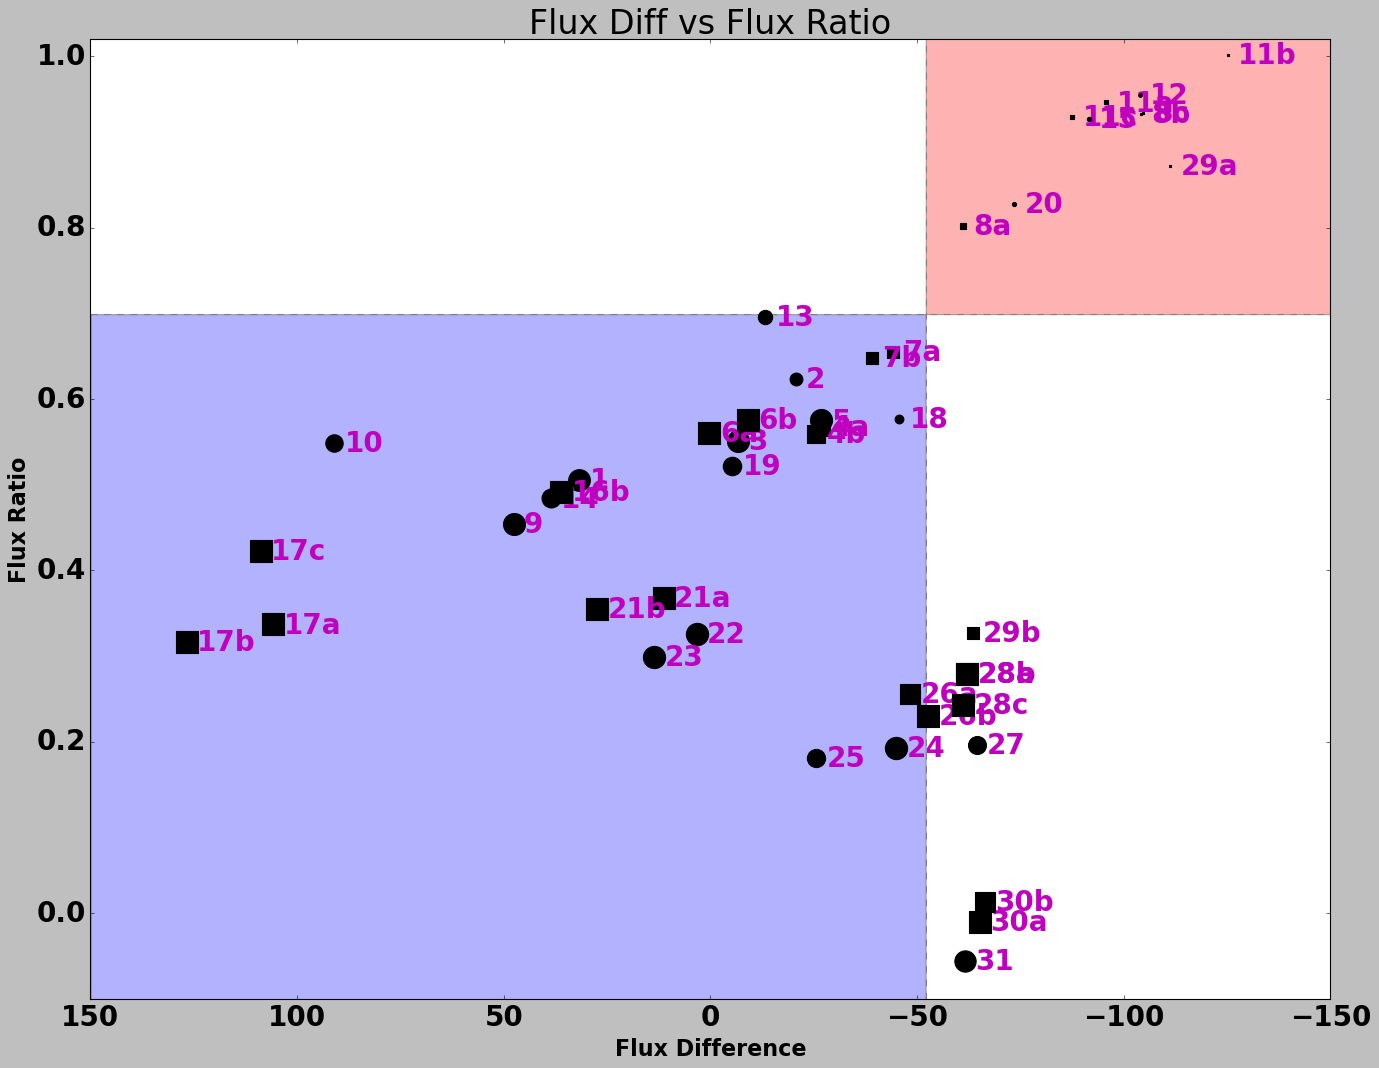

In [8]:
####FLUX DIFF vs FLUX RATIO WITH EXTINCTION FRAC SIZES###
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,15))


for i in range(0,len(cat_tex)):
    if cat_tex['index'][i][-1].isalpha():
        if np.isnan(cat_tex['ext_frac_max'][i]) == False:
            sc = ax.scatter(cat_tex['flux_diff_max'][i], cat_tex['flux_ratio_max'][i], marker='s', c='k', s=400 ** cat_tex['ext_frac_max'][i], edgecolor='k', zorder=3)
            ax.annotate(cat_tex['index'][i],(cat_tex['flux_diff_max'][i]-2.5, cat_tex['flux_ratio_max'][i] - 0.01),c='m')
    else:
        sc = ax.scatter(cat_tex['flux_diff_max'][i], cat_tex['flux_ratio_max'][i], marker='o', c='k', s=400 ** cat_tex['ext_frac_max'][i], edgecolor='k', zorder=3)  
        ax.annotate(cat_tex['index'][i],(cat_tex['flux_diff_max'][i]-2.5, cat_tex['flux_ratio_max'][i] - 0.01),c='m')
    




ax.invert_xaxis()
ax.axvline(x = -fore, linestyle ='--', color = 'grey' )
ax.axhline(y = flux_ratio_center,linestyle ='--', color = 'grey' )


near_range = np.arange(-fore,150,.1)
far_range = np.arange(-150,-fore , 0.1)
ax.fill_between(near_range, -0.2 ,flux_ratio_center, facecolor = 'blue', alpha=0.3)
ax.fill_between(far_range ,flux_ratio_center,1.1, facecolor = 'red', alpha=0.3)

plt.title("Flux Diff vs Flux Ratio", fontsize=30)
ax.set_xlabel('Flux Difference', fontsize=20)
ax.set_ylabel('Flux Ratio', fontsize=20)
plt.xlim(150,-150)
plt.ylim(-0.1,1.02)

plt.savefig('flux_ratio_vs_flux_diff_with_E_updated.png')


plt.show()

/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_24270/3441562527.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  j.yaxis.set_ticklabels([r'-0.30$^{\circ}$'," " , r'-0.20$^{\circ}$'," " , r'-0.10$^{\circ}$'," " , r'0.00$^{\circ}$'," " , " "], fontsize=20)
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_24270/3441562527.py:160: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, fontsize=20,rotation=-30)
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_24270/3441562527.py:166: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels([r'',r'359.4$^{\circ}$',r'359.6$^{\circ}$',r'359.8$^{\circ}$',r'0.0$^{\circ}$',r'0.2$^{\circ}$',
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_24270/3441562527.py:218: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt

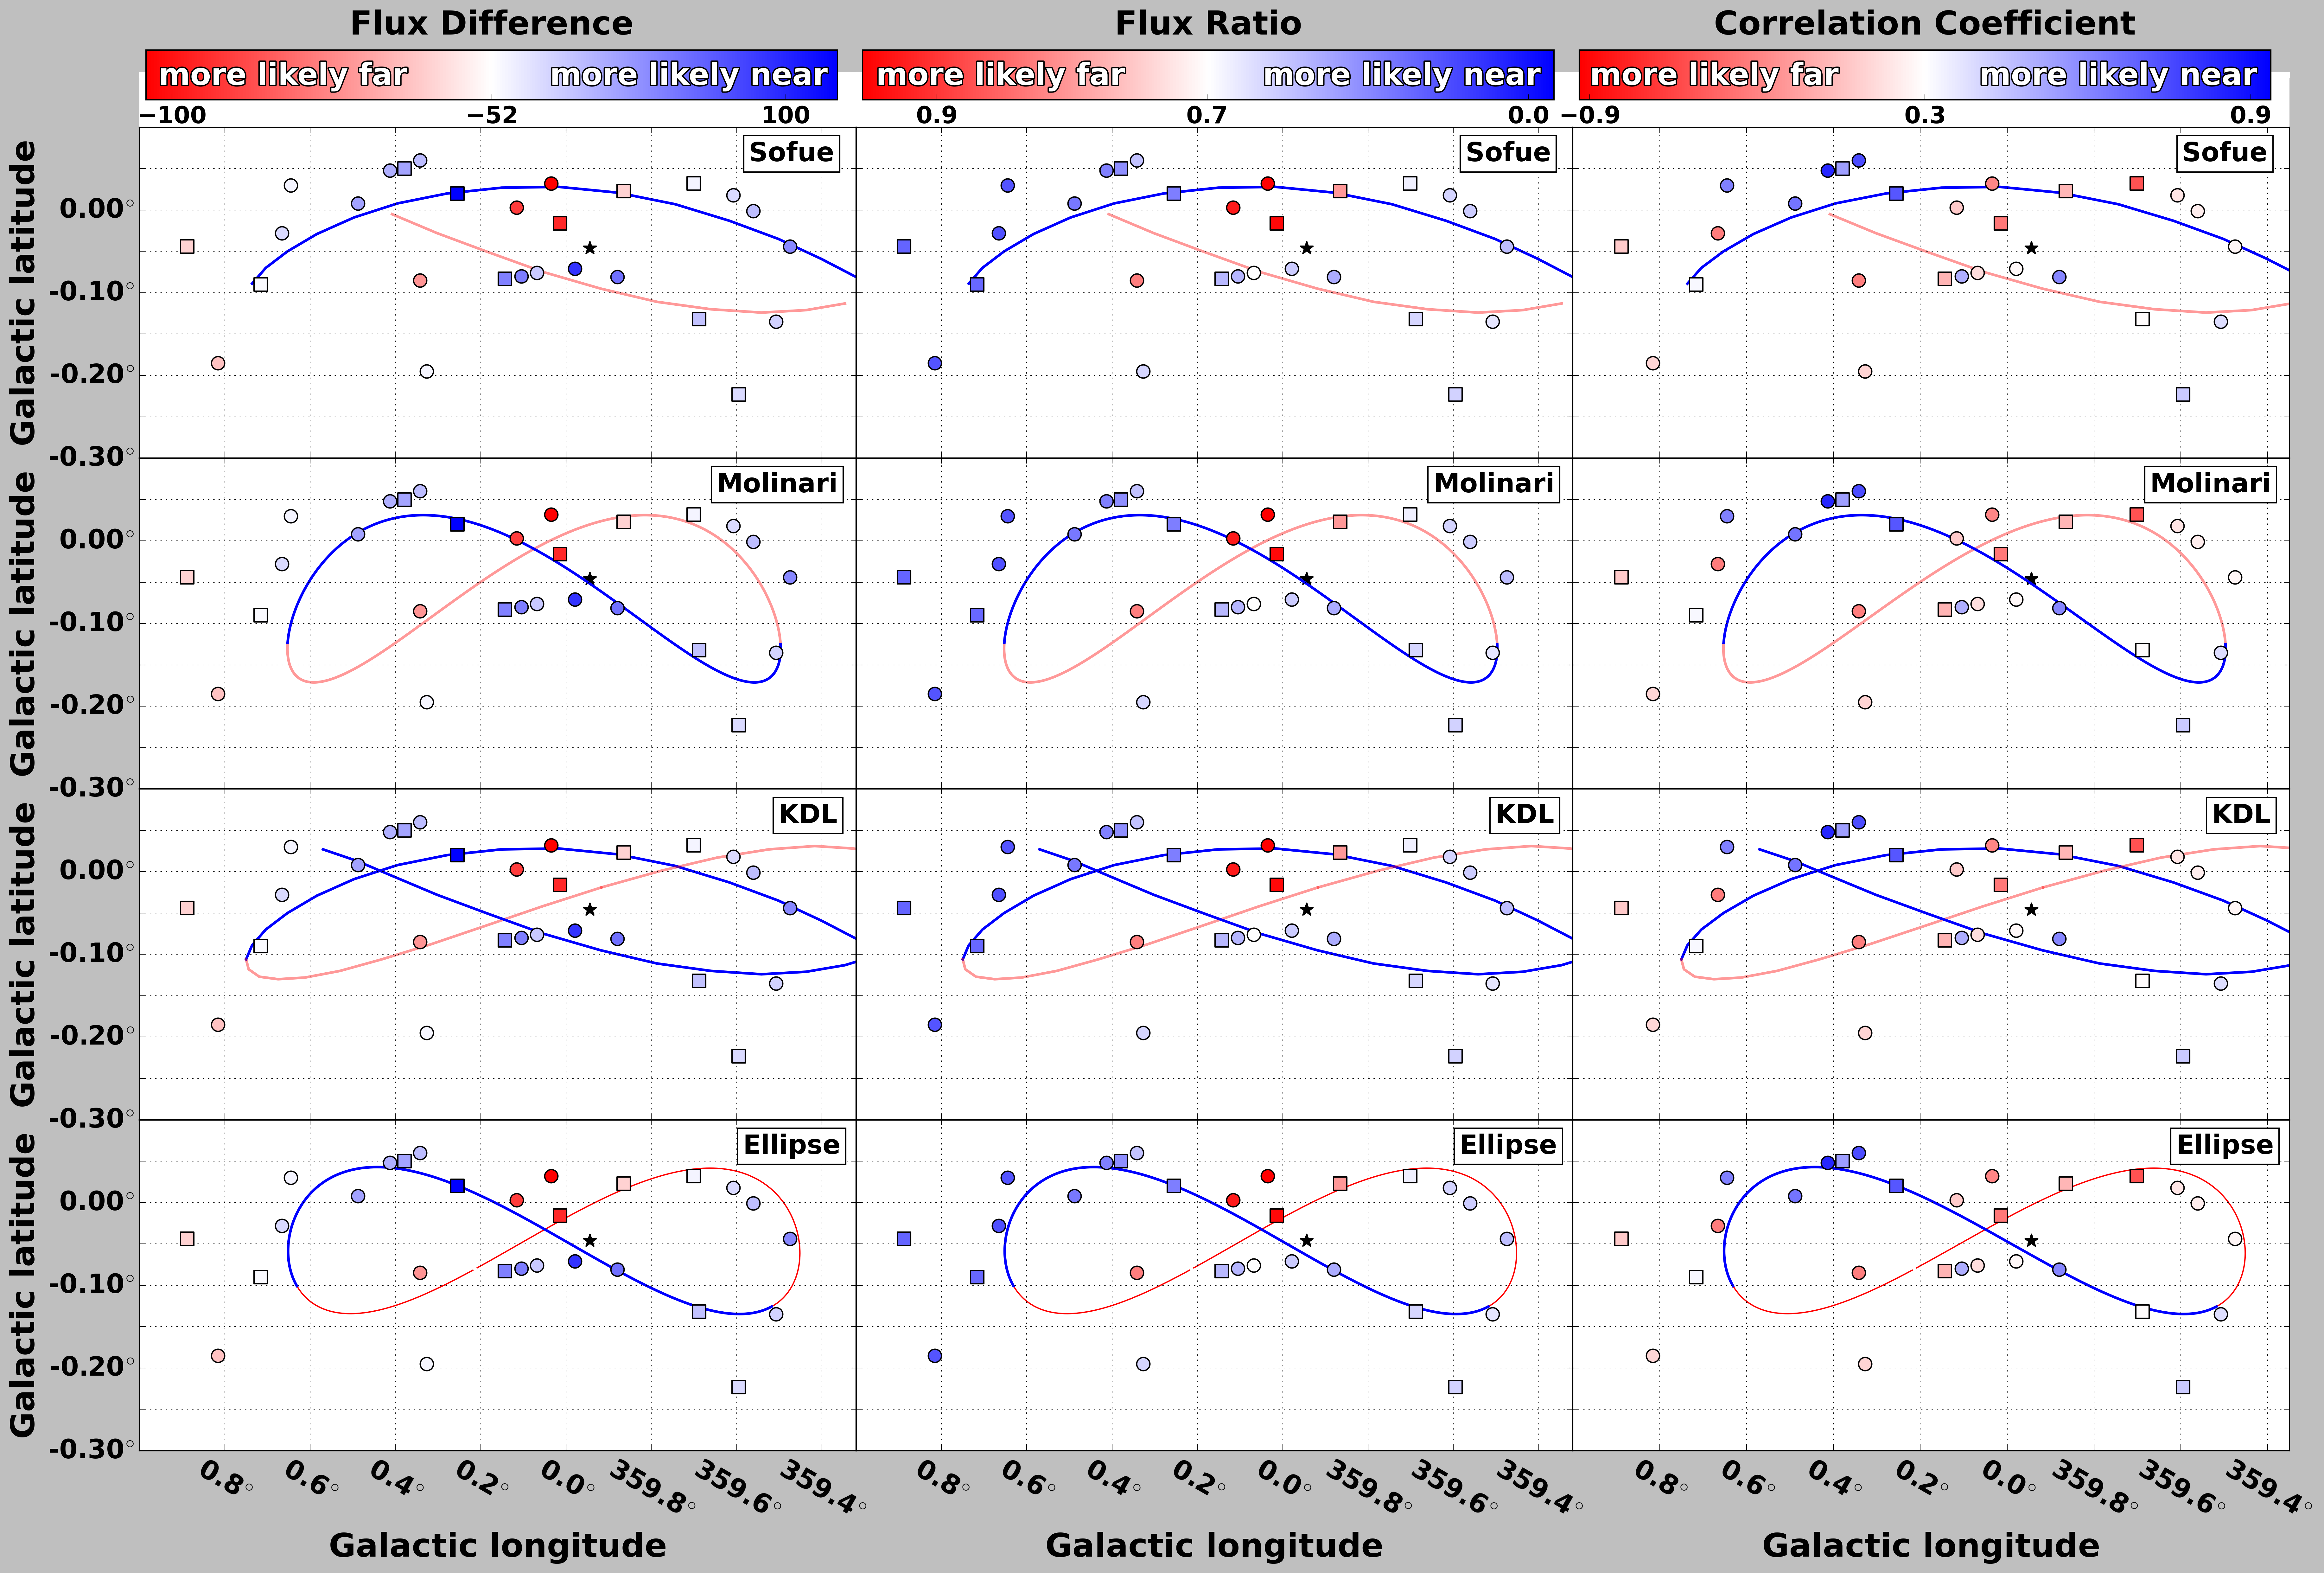

<Figure size 640x480 with 0 Axes>

In [9]:
plt.rcParams.update({'font.size': 15})

fxsz = 25
xyrat = 2./3.
fysz = fxsz * xyrat
ds = 0.05
fig = plt.figure( figsize=(fxsz,fysz), dpi=300)
gs = GridSpec(26,9)
gs.update(left=0.07, right=1-0.025, bottom=0.085, top=1-0.01, hspace=0, wspace=0)

#Colorbars
axes1 = plt.subplot(gs[1, :3])
axes2 = plt.subplot(gs[1,3:6])
axes3 = plt.subplot(gs[1,6:9])


axes4 = plt.subplot(gs[2:8,:3])
axes5 = plt.subplot(gs[8:14,:3])
axes6 = plt.subplot(gs[14:20,:3])
axes7 = plt.subplot(gs[20:26,:3])

axes8 = plt.subplot(gs[2:8,3:6])
axes9 = plt.subplot(gs[8:14,3:6])
axes10 = plt.subplot(gs[14:20,3:6])
axes11 = plt.subplot(gs[20:26,3:6])

axes12 = plt.subplot(gs[2:8,6:9])
axes13 = plt.subplot(gs[8:14,6:9])
axes14 = plt.subplot(gs[14:20,6:9])
axes15 = plt.subplot(gs[20:26,6:9])





###FLUX DIFF POINTS###
for j in [axes4,axes5,axes6,axes7]:
    divnorm = mc.TwoSlopeNorm(vmin=np.nanmin(cat_agg['flux_diff_max']), vcenter=-52.09, vmax=np.nanmax(cat_agg['flux_diff_max']))
    for i in range(0,len(cat_agg)):
        if cat_agg['index'][i][-1].isalpha():
            sc1 = j.scatter(cat_agg['l'][i], cat_agg['b'][i], marker='s', s=100, edgecolor='k', zorder=3, c=cat_agg['flux_diff_max'][i], cmap='bwr_r', norm=divnorm)
            #j.scatter(cat_agg['l'][i], cat_agg['b'][i], marker='$\\bigoplus$', s=140, edgecolor='k', zorder=3, c='k')
        else:
            j.scatter(cat_agg['l'][i], cat_agg['b'][i], marker=r'o', s=100, edgecolor='k', zorder=3, c=cat_agg['flux_diff_max'][i], cmap='bwr_r', norm=divnorm)   
    j.scatter(-0.056, -0.046, marker = "*", s=100, color='k')
    j.grid(True)
    j.set_xlim(1,-0.68)
    j.set_ylim(-0.3,0.1)
    j.set_rasterized(True)
    j.yaxis.set_ticklabels([r'-0.30$^{\circ}$'," " , r'-0.20$^{\circ}$'," " , r'-0.10$^{\circ}$'," " , r'0.00$^{\circ}$'," " , " "], fontsize=20)
    j.set_ylabel('Galactic latitude',fontsize=25)
    

##FLUX RATIO POINTS###
for j in [axes8,axes9,axes10,axes11]:
    for i in range(0,len(cat_agg)):
        divnorm =mc.TwoSlopeNorm(vmin=np.nanmin(cat_agg['flux_ratio_max']), vcenter=flux_ratio_center, vmax=np.nanmax(cat_agg['flux_ratio_max']))
        if cat_agg['index'][i][-1].isalpha():
            sc2 = j.scatter(cat_agg['l'][i], cat_agg['b'][i], marker='s', s=100, edgecolor='k', zorder=3, c=cat_agg['flux_ratio_max'][i], cmap='bwr', norm=divnorm)
            #j.scatter(cat_agg['l'][i], cat_agg['b'][i], marker='$\\bigoplus$', s=140, edgecolor='k', zorder=3, c='k')
        else:
            j.scatter(cat_agg['l'][i], cat_agg['b'][i], marker=r'o', s=100, edgecolor='k', zorder=3, c=cat_agg['flux_ratio_max'][i], cmap='bwr', norm=divnorm)    
    j.scatter(-0.056, -0.046, marker = "*", s=100, color='k')
    j.grid(True)
    j.set_xlim(1,-0.68)
    j.set_ylim(-0.3,0.1)
    j.set_rasterized(True)   
    j.yaxis.set_ticklabels([])
    

#CORR COEFF POINTS###    
for j in [axes12,axes13,axes14,axes15]:
    divnorm = mc.TwoSlopeNorm(vmin=np.nanmin(corr_coeff_use), vcenter=0.3, vmax=np.nanmax(corr_coeff_use))
    for i in range(0,len(cat_agg)):
        if cat_agg['index'][i][-1].isalpha():
            sc3 = j.scatter(cat_agg['l'][i], cat_agg['b'][i], marker=r's', s=100, edgecolor='k', zorder=3, c=cat_agg['r_p_max'][i], cmap='bwr_r', norm=divnorm)
            #j.scatter(cat_agg['l'][i], cat_agg['b'][i], marker='$\\bigoplus$', s=140, edgecolor='k', zorder=3, c='k')
        else:
            sc3 = j.scatter(cat_agg['l'][i], cat_agg['b'][i], marker=r'o', s=100, edgecolor='k', zorder=3, c=cat_agg['r_p_max'][i], cmap='bwr_r', norm=divnorm)     
    j.scatter(-0.056, -0.046, marker = "*", s=100, color='k')
    j.grid(True)
    j.set_xlim(1,-0.65)
    j.set_ylim(-0.3,0.1)
    j.set_rasterized(True)
    j.yaxis.set_ticklabels([])

    
    

    
###ORBITAL MODELS###

"""
#Sofue
"""
for ax in [axes4, axes8, axes12]:
    sofue1 = np.loadtxt('sofue_lbv_arm1.txt', unpack=True)
    sofue1_l, sofue1_b, sofue1_v = sofue1[0], sofue1[1], sofue1[2]
    ax.plot(sofue1_l, sofue1_b, ls='-', color='blue', linewidth=2, zorder=2)

    sofue2 = np.loadtxt('sofue_lbv_arm2.txt', unpack=True)
    sofue2_l, sofue2_b, sofue2_v = sofue2[0], sofue2[1], sofue2[2]
    ax.plot(sofue2_l, sofue2_b, ls='-', color='red', linewidth=2, zorder=2, alpha=0.4)
    ax.xaxis.set_ticklabels([])
    #ax.yaxis.set_ticklabels([-.30," " , -0.20," " , -.10," " , 0.00," " , " "])
    ax.text(0.91, 0.92,'Sofue', ha='center', va='center', transform=ax.transAxes,
               bbox=dict(facecolor='white', edgecolor='k', alpha=1),fontsize=20)
    #ax.set_ylabel('Galactic latitude')
    
"""
#Molinari
"""
for ax in [axes5, axes9, axes13]:

    ml = np.loadtxt('molinari_lbvlos.txt', unpack=True)
    lk, bk, vk = ml[0], ml[1], ml[2]
    ax.plot(-1*lk[80:580], bk[80:580], ls='-', color='red', linewidth=2, zorder=2, alpha=0.4)
    ax.plot(-1*lk[0:80], bk[0:80], ls='-', color='blue', linewidth=2, zorder=2)
    ax.plot(-1*lk[581:], bk[581:], ls='-', color='blue', linewidth=2, zorder=2)
    ax.text(0.89, 0.92,'Molinari', ha='center', va='center', transform=ax.transAxes,
               bbox=dict(facecolor='white', edgecolor='k', alpha=1), fontsize=20)

    ax.xaxis.set_ticklabels([])
    #ax.yaxis.set_ticklabels([-.30," " , -0.20," " , -.10," " , 0.00," " , " "])
    #ax.set_ylabel('Galactic latitude')
    

"""
#KDL
"""   
for ax in [axes6, axes10, axes14]:
    
    kdl = np.loadtxt('kdl_lbv.txt', unpack=True)
    lk, bk, vk = kdl[0], kdl[1], kdl[2]
    ax.plot(lk[0:16], bk[0:16], ls='-', color='blue', linewidth=2, zorder=2)
    ax.plot(lk[15:26], bk[15:26], ls='-', color='red', linewidth=2, zorder=2, alpha=0.4)
    ax.plot(lk[25:36], bk[25:36], ls='-', color='red', linewidth=2, zorder=2, alpha=0.4)
    ax.plot(lk[35:51], bk[35:51], ls='-', color='blue', linewidth=2, zorder=2)
    ax.xaxis.set_ticklabels([])
    #ax.yaxis.set_ticklabels([-.30," " , -0.20," " , -.10," " , 0.00," " , " "])

    ax.text(0.933, 0.92,'KDL', ha='center', va='center', transform=ax.transAxes,
               bbox=dict(facecolor='white', edgecolor='k', alpha=1), fontsize=20)

    #ax.set_ylabel('Galactic latitude')
    
    
"""
#Rings
"""
for ax in [axes7,axes11,axes15]:

    ax.plot(np.degrees(Rings.l[back_ind[0:-1]]),np.degrees(Rings.b[back_ind[0:-1]]),c='red')
    ax.plot(np.degrees(Rings.l[fore_ind[0:]]),np.degrees(Rings.b[fore_ind[0:]]),c='blue', linewidth=2, zorder=2)

    #ax.set_xticks([1.0, 0.8, 0.6, 0.4, 0.2, 0.0, -0.2, -0.4, " "])
    plt.draw()
    labels = ax.get_xticklabels()
    labels[0] = labels[-1] = " "
    ax.set_xticklabels(labels, fontsize=20,rotation=-30)
    
    ax.text(0.91, 0.92,'Ellipse', ha='center', va='center', transform=ax.transAxes,
           bbox=dict(facecolor='white', edgecolor='k', alpha=1),fontsize=20)
    ax.set_xlabel('Galactic longitude', fontsize=25)
    
    ax.xaxis.set_ticklabels([r'',r'359.4$^{\circ}$',r'359.6$^{\circ}$',r'359.8$^{\circ}$',r'0.0$^{\circ}$',r'0.2$^{\circ}$',
                           r'0.4$^{\circ}$',r'0.6$^{\circ}$',r'0.8$^{\circ}$',])
    



cax_points1 = [0.009,0.50,0.965,0.90]
cax_points2 = [0.009,0.50,0.965,0.90]
cax_points3 = [0.009,0.50,0.965,0.90]
cax1 = axes1.inset_axes(cax_points1)
cax2 = axes2.inset_axes(cax_points2)
cax3 = axes3.inset_axes(cax_points3)
cb1 = fig.colorbar(ax = axes1, mappable = sc1, cax = cax1, orientation = 'horizontal', ticks=[-100, -52, 100])
cb2 = fig.colorbar(ax = axes2, mappable = sc2, cax = cax2, orientation = 'horizontal', ticks=[0, 0.7, 0.9])
cb3 = fig.colorbar(ax = axes3, mappable = sc3, cax = cax3, orientation = 'horizontal', ticks=[-0.9, 0.3, 0.9])





for spine in axes1.spines.values():
    spine.set_visible(False)
for spine in axes2.spines.values():
    spine.set_visible(False)
for spine in axes3.spines.values():
    spine.set_visible(False)
    
for ax in [axes1,axes2,axes3]:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis='both',which='both',bottom=False,left=False, color='white')
    
cb1.set_label(r'Flux Difference',loc='center',labelpad=-90, fontsize=25)
cb2.set_label(r'Flux Ratio',loc='center',labelpad=-90, fontsize=25)
cb3.set_label(r'Correlation Coefficient',loc='center',labelpad=-90, fontsize=25)
cb1.ax.tick_params(labelsize=18)
cb2.ax.tick_params(labelsize=18)
cb3.ax.tick_params(labelsize=18)

cb2.ax.invert_xaxis()

import matplotlib.patheffects as pe
cb1.ax.text(-22, 0.3, r'more likely near', color='white', rotation=0, fontsize=23, weight='bold',path_effects=[pe.withStroke(linewidth=2, foreground="black")])
cb1.ax.text(-102, 0.3 , r'more likely far', color='white', rotation=0, fontsize=23, weight='bold',path_effects=[pe.withStroke(linewidth=2, foreground="black")])

cb2.ax.text(0.58, 0.3, r'more likely near', color='white', rotation=0, fontsize=23, weight='bold',path_effects=[pe.withStroke(linewidth=2, foreground="black")])
cb2.ax.text(0.945, 0.3 , r'more likely far', color='white', rotation=0, fontsize=23, weight='bold',path_effects=[pe.withStroke(linewidth=2, foreground="black")])

cb3.ax.text(0.4, 0.3, r'more likely near', color='white', rotation=0, fontsize=23, weight='bold',path_effects=[pe.withStroke(linewidth=2, foreground="black")])
cb3.ax.text(-0.9, 0.3 , r'more likely far', color='white', rotation=0, fontsize=23, weight='bold',path_effects=[pe.withStroke(linewidth=2, foreground="black")])


plt.tight_layout()
plt.savefig('onecol_3d_models_lb_THREE_COMBINED.pdf')

plt.show()


plt.clf()



# Normalize?


In [10]:
cat_agg.pprint_all()

index   cloud_name     l      b     v   sigma rad absorp r_p_mom0 r_s_mom0 r_p_max r_s_max flux_diff_mom0 flux_ratio_mom0 I_cloud_max I_model_max flux_diff_max flux_ratio_max ext_frac_max lb_pixel_mask NF_decision min_flux_max
----- -------------- ------ ------ ---- ----- --- ------ -------- -------- ------- ------- -------------- --------------- ----------- ----------- ------------- -------------- ------------ ------------- ----------- ------------
    1 G359.475-0.044 -0.525 -0.044 -102     6 4.3      3    0.261    0.444   0.261   0.444         31.669           0.506     212.667     317.106        31.669          0.506        0.992             1          LN       82.971
    2 G359.508-0.135 -0.492 -0.135  -56     9 8.7      3    0.384    0.397   0.384   0.397        -20.608           0.623     224.209     276.371       -20.608          0.623        0.815             1           N      117.934
    3 G359.561-0.001 -0.439 -0.001  -90     8 2.7      0    0.222    0.325   0.222   0.325  

/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_24270/3113524724.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].yaxis.set_ticklabels([-.30," " , -0.20," " , -.10," " , 0.00," " , " "])
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_24270/3113524724.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].yaxis.set_ticklabels([-.30," " , -0.20," " , -.10," " , 0.00," " , " "])
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_24270/3113524724.py:92: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].yaxis.set_ticklabels([-.30," " , -0.20," " , -.10," " , 0.00," " , " "])
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_24270/3113524724.py:108: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[3].yaxis.set_ticklabels([-.30," " , -0.20," " , -.10," " , 0.00," " , " "])


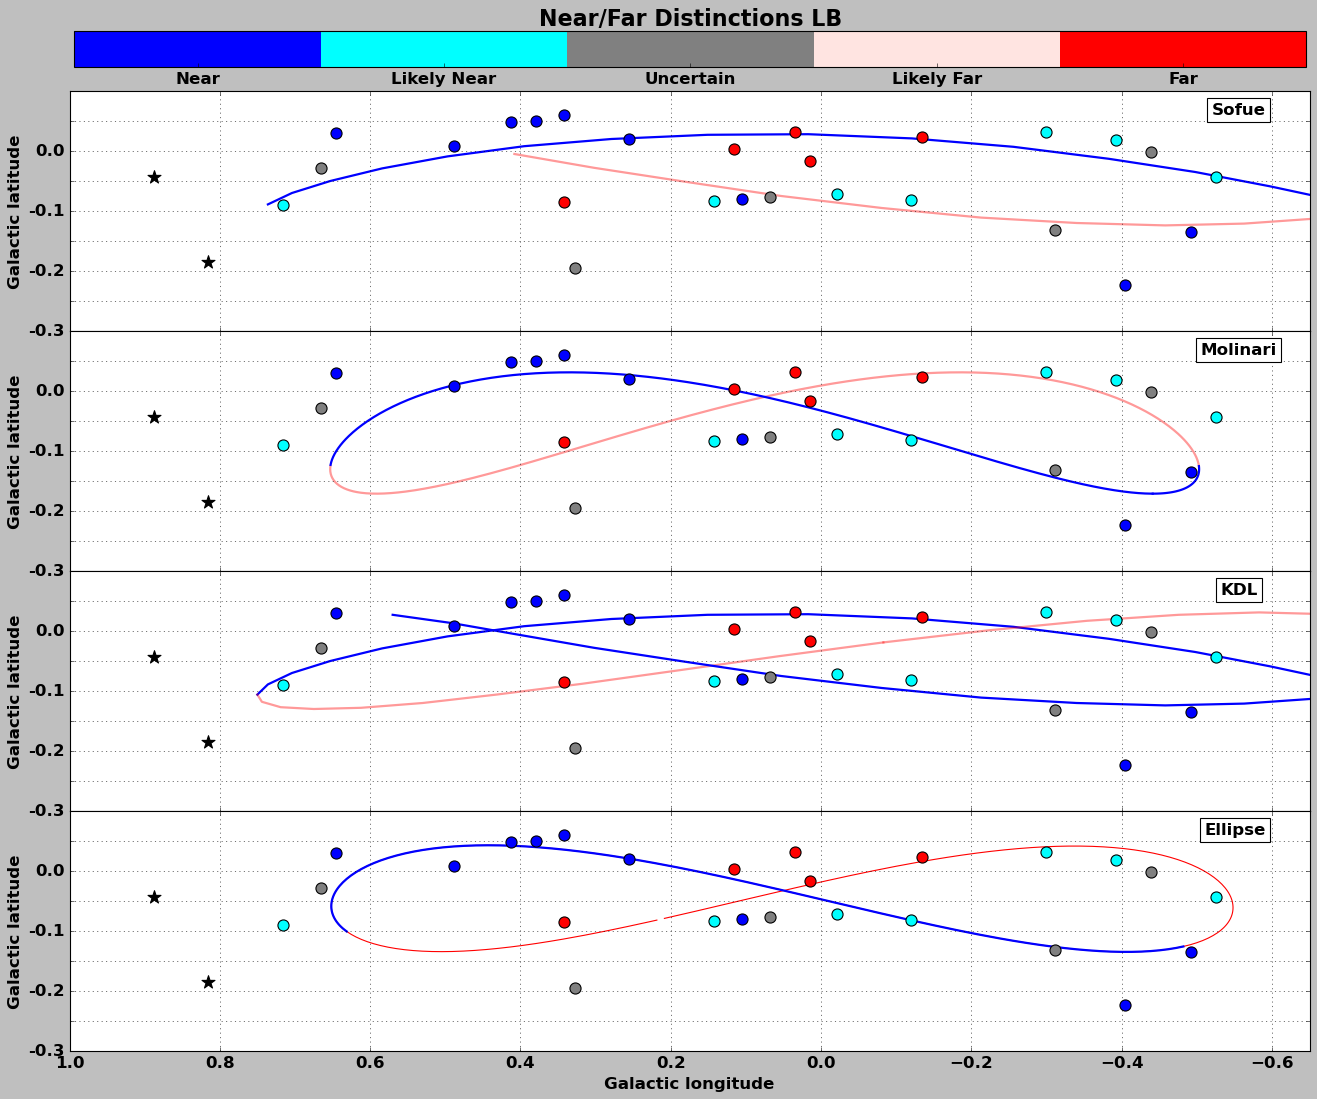

<Figure size 640x480 with 0 Axes>

In [11]:
####SINGLE COLUMN DUST EXTINCTION (RESIZED)####
####MEGA LB PLOT####

NFU = cat_agg['NF_decision']

color_list = ['blue', 'cyan', 'gray' ,'mistyrose', 'red']
cmap = (mpl.colors.ListedColormap(color_list))

l   = scouse_fits['l'].values
b   = scouse_fits['b'].values
v   = scouse_fits['velocity'].values
amp = scouse_fits['amp'].values



fig, ax = plt.subplots(nrows=4, ncols=1,  figsize=(20,15))
plt.subplots_adjust(wspace=0, hspace=0)


for row in ax:
    for i in range(0,len(cat_agg)):
        if cat_agg['NF_decision'][i] == 'N':
            sc = row.scatter(cat_agg['l'][i], cat_agg['b'][i], marker='o', s=100, edgecolor='k', zorder=3, c=color_list[0],  norm=divnorm)
            
        if cat_agg['NF_decision'][i] == 'LN':
            sc = row.scatter(cat_agg['l'][i], cat_agg['b'][i], marker='o', s=100, edgecolor='k', zorder=3, c=color_list[1],  norm=divnorm)            
            
        if cat_agg['NF_decision'][i] == 'LF':
            sc = row.scatter(cat_agg['l'][i], cat_agg['b'][i], marker='o', s=100, edgecolor='k', zorder=3, c=color_list[3],  norm=divnorm)
            
        if cat_agg['NF_decision'][i] == 'F':
            sc = row.scatter(cat_agg['l'][i], cat_agg['b'][i], marker='o', s=100, edgecolor='k', zorder=3, c=color_list[4],  norm=divnorm)
            
        if cat_agg['NF_decision'][i] == 'U':
            sc = row.scatter(cat_agg['l'][i], cat_agg['b'][i], marker='o', s=100, edgecolor='k', zorder=3, c=color_list[2],  norm=divnorm)
            
        if cat_agg['NF_decision'][i] == 'nan':
            row.scatter(cat_agg['l'][i], cat_agg['b'][i], marker='*', s=150, edgecolor='k', zorder=3, c='k')     

    row.grid(True)
    row.set_xlim(1,-0.65)
    row.set_ylim(-0.3,0.1)
    row.set_rasterized(True)



"""
#Sofue
"""
sofue1 = np.loadtxt('sofue_lbv_arm1.txt', unpack=True)
sofue1_l, sofue1_b, sofue1_v = sofue1[0], sofue1[1], sofue1[2]
ax[0].plot(sofue1_l, sofue1_b, ls='-', color='blue', linewidth=2, zorder=2)

sofue2 = np.loadtxt('sofue_lbv_arm2.txt', unpack=True)
sofue2_l, sofue2_b, sofue2_v = sofue2[0], sofue2[1], sofue2[2]
ax[0].plot(sofue2_l, sofue2_b, ls='-', color='red', linewidth=2, zorder=2, alpha=0.4)
ax[0].xaxis.set_ticklabels([])
ax[0].yaxis.set_ticklabels([-.30," " , -0.20," " , -.10," " , 0.00," " , " "])
ax[0].text(0.943, 0.92,'Sofue', ha='center', va='center', transform=ax[0].transAxes,
           bbox=dict(facecolor='white', edgecolor='k', alpha=1))
ax[0].set_ylabel('Galactic latitude')

"""


#Molinari
"""
ml = np.loadtxt('molinari_lbvlos.txt', unpack=True)
lk, bk, vk = ml[0], ml[1], ml[2]
ax[1].plot(-1*lk[80:580], bk[80:580], ls='-', color='red', linewidth=2, zorder=2, alpha=0.4)
ax[1].plot(-1*lk[0:80], bk[0:80], ls='-', color='blue', linewidth=2, zorder=2)
ax[1].plot(-1*lk[581:], bk[581:], ls='-', color='blue', linewidth=2, zorder=2)
ax[1].text(0.943, 0.92,'Molinari', ha='center', va='center', transform=ax[1].transAxes,
           bbox=dict(facecolor='white', edgecolor='k', alpha=1))

ax[1].xaxis.set_ticklabels([])
ax[1].yaxis.set_ticklabels([-.30," " , -0.20," " , -.10," " , 0.00," " , " "])
ax[1].set_ylabel('Galactic latitude')



"""
#KDL
"""
kdl = np.loadtxt('kdl_lbv.txt', unpack=True)
lk, bk, vk = kdl[0], kdl[1], kdl[2]
ax[2].plot(lk[0:16], bk[0:16], ls='-', color='blue', linewidth=2, zorder=2)
ax[2].plot(lk[15:26], bk[15:26], ls='-', color='red', linewidth=2, zorder=2, alpha=0.4)
ax[2].plot(lk[25:36], bk[25:36], ls='-', color='red', linewidth=2, zorder=2, alpha=0.4)
ax[2].plot(lk[35:51], bk[35:51], ls='-', color='blue', linewidth=2, zorder=2)
ax[2].xaxis.set_ticklabels([])
ax[2].yaxis.set_ticklabels([-.30," " , -0.20," " , -.10," " , 0.00," " , " "])

ax[2].text(0.943, 0.92,'KDL', ha='center', va='center', transform=ax[2].transAxes,
           bbox=dict(facecolor='white', edgecolor='k', alpha=1))

ax[2].set_ylabel('Galactic latitude')


"""
#Rings
"""


ax[3].plot(np.degrees(Rings.l[back_ind[0:-1]]),np.degrees(Rings.b[back_ind[0:-1]]),c='red')
ax[3].plot(np.degrees(Rings.l[fore_ind[0:]]),np.degrees(Rings.b[fore_ind[0:]]),c='blue', linewidth=2, zorder=2)

ax[3].yaxis.set_ticklabels([-.30," " , -0.20," " , -.10," " , 0.00," " , " "])
ax[3].text(0.94, 0.92,'Ellipse', ha='center', va='center', transform=ax[3].transAxes,
           bbox=dict(facecolor='white', edgecolor='k', alpha=1))


ax[3].set_xlabel('Galactic longitude')
ax[3].set_ylabel('Galactic latitude')

cax = fig.add_axes([0.128, .92, 0.77, 0.03])


bounds = [1, 2, 3, 4, 5, 6]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb = fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=[1.5,2.5,3.5,4.5,5.5],
    spacing='proportional',
    orientation='horizontal',
    #label='Discrete intervals, some other units',
)

cb.ax.set_xticklabels(['Near', 'Likely Near', 'Uncertain', 'Likely Far', 'Far'])


#cb = plt.colorbar(sc, ax=ax.ravel().tolist(), orientation='horizontal', cax=cax)
cb.ax.set_title('Near/Far Distinctions LB', size=20, fontweight='bold', fontname='sans-serif')

plt.savefig('../paper_figs/Figs/onecol_3d_models_lb_ellipse_colorbar_MEGAPLOT.png')
plt.show()


plt.clf()

In [12]:
ellipse_tab = Table.read('./cloud_catalogue_trimmed.csv')
cloud_id = ellipse_tab['_idx']
cloud_major_sigma = ellipse_tab['major_sigma']
cloud_minor_sigma = ellipse_tab['minor_sigma']
cloud_PA =  ellipse_tab['position_angle']
cloud_rad = ellipse_tab['rad']

ellipse_tab

_idx,major_sigma,minor_sigma,position_angle,rad
int64,float64,float64,float64,float64
1,0.02645096,0.009829875,169.0956733,4.3
2,0.042421993,0.027261216,-167.6093533,8.7
3,0.020831891,0.005659255,173.0560869,2.7
4,0.023747707,0.010305772,-150.5666158,4.6
5,0.011519529,0.004421141,167.2449998,2.0
6,0.037680116,0.011706452,-175.6349221,5.6
7,0.014741912,0.007124793,122.8857362,2.4
8,0.010416911,0.004724533,-162.6472607,2.0
9,0.023505779,0.011436573,166.3481656,5.0


22.999999999999996
1.0
1.0


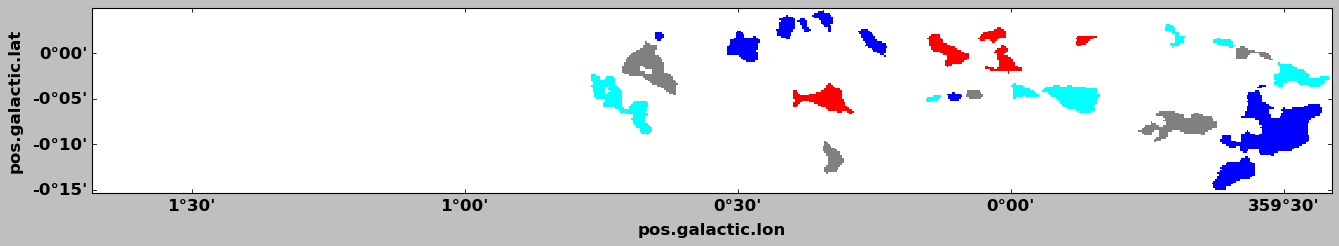

In [13]:
from astropy import wcs
import copy

full_id_mask = fits.open('../FITS/id_mask_mosaic.fits')[0]
id_mask_wcs = wcs.WCS(full_id_mask.header)

full_id_contours = copy.deepcopy(full_id_mask.data)
full_id_contours[np.where(np.isnan(full_id_mask.data) == True)] = 0
full_id_contours[np.where(full_id_mask.data>=27)] = 0


full_mosaic_cmapped = copy.deepcopy(full_id_mask.data)
full_mosaic_cmapped[np.where(np.isnan(full_id_mask.data) == True)] = np.nan
full_mosaic_cmapped[np.where(full_id_mask.data>=27)] = np.nan

#full_mosaic_cmapped = np.empty_like(full_id_mask.data)
#full_mosaic_cmapped.fill(np.nan)

N_ind = np.where(cat_agg['NF_decision']=='N')
LN_ind = np.where(cat_agg['NF_decision']=='LN')
U_ind = np.where(cat_agg['NF_decision']=='U')
LF_ind = np.where(cat_agg['NF_decision']=='LF')
F_ind = np.where(cat_agg['NF_decision']=='F')
non_ind = np.where(cat_agg['NF_decision']=='nan')



for i in N_ind[0]:
    full_mosaic_cmapped[np.round(full_id_mask.data) ==i+1] = 1
    full_id_contours[np.round(full_id_mask.data) ==i+1] = 1
for i in LN_ind[0]:
    full_mosaic_cmapped[np.round(full_id_mask.data) ==i+1] = 2
    full_id_contours[np.round(full_id_mask.data) ==i+1] = 2
    
for i in U_ind[0]:
    full_mosaic_cmapped[np.round(full_id_mask.data) ==i+1] = 3
    full_id_contours[np.round(full_id_mask.data) ==i+1] = 3
    
for i in LF_ind[0]:
    full_mosaic_cmapped[np.round(full_id_mask.data) ==i+1] = 4
    full_id_contours[np.round(full_id_mask.data) ==i+1] = 4
    
for i in F_ind[0]:
    full_mosaic_cmapped[np.round(full_id_mask.data) ==i+1] = 5
    full_id_contours[np.round(full_id_mask.data) ==i+1] = 5
    
     
    
    
    
fits.writeto('../FITS/id_mask_mosaic_qualitative.fits', full_mosaic_cmapped, full_id_mask.header, overwrite=True)
fits.writeto('../FITS/id_mask_mosaic_zeros.fits', full_id_contours, full_id_mask.header, overwrite=True)


color_list = ['blue', 'cyan', 'gray' ,'mistyrose', 'red']
cmap = (mpl.colors.ListedColormap(color_list))

bounds=[1,2,3,4,5,6]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection': id_mask_wcs},  figsize=(20,8))
ax.imshow(full_mosaic_cmapped,interpolation='nearest', origin='lower', cmap=cmap, norm=norm)  


#ax.contour(full_id_contours, levels=[0,1], colors='black')

#ax.contourf(full_id_mask.data==22, levels=np.arange(0.5,27,0.5), colors='green')


print(full_id_mask.data[80][368])
print(full_mosaic_cmapped[80][368])

print(full_id_contours[80][368])

In [242]:
id_tab = Table.read("../paper_figs/Tables/CMZ_cloud_catalogue_data.csv")
leaf_id_num = id_tab['index']
id_l = id_tab['l']
id_b = id_tab['b']


/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_5030/496513934.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].yaxis.set_ticklabels([-.30," " , -0.20," " , -.10," " , 0.00," " , " "])
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_5030/496513934.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].yaxis.set_ticklabels([-.30," " , -0.20," " , -.10," " , 0.00," " , " "])
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_5030/496513934.py:94: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].yaxis.set_ticklabels([-.30," " , -0.20," " , -.10," " , 0.00," " , " "])
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_5030/496513934.py:115: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[3].yaxis.set_ticklabels([-.30," " , -0.20," " , -.10," " , 0.00," " , " "])


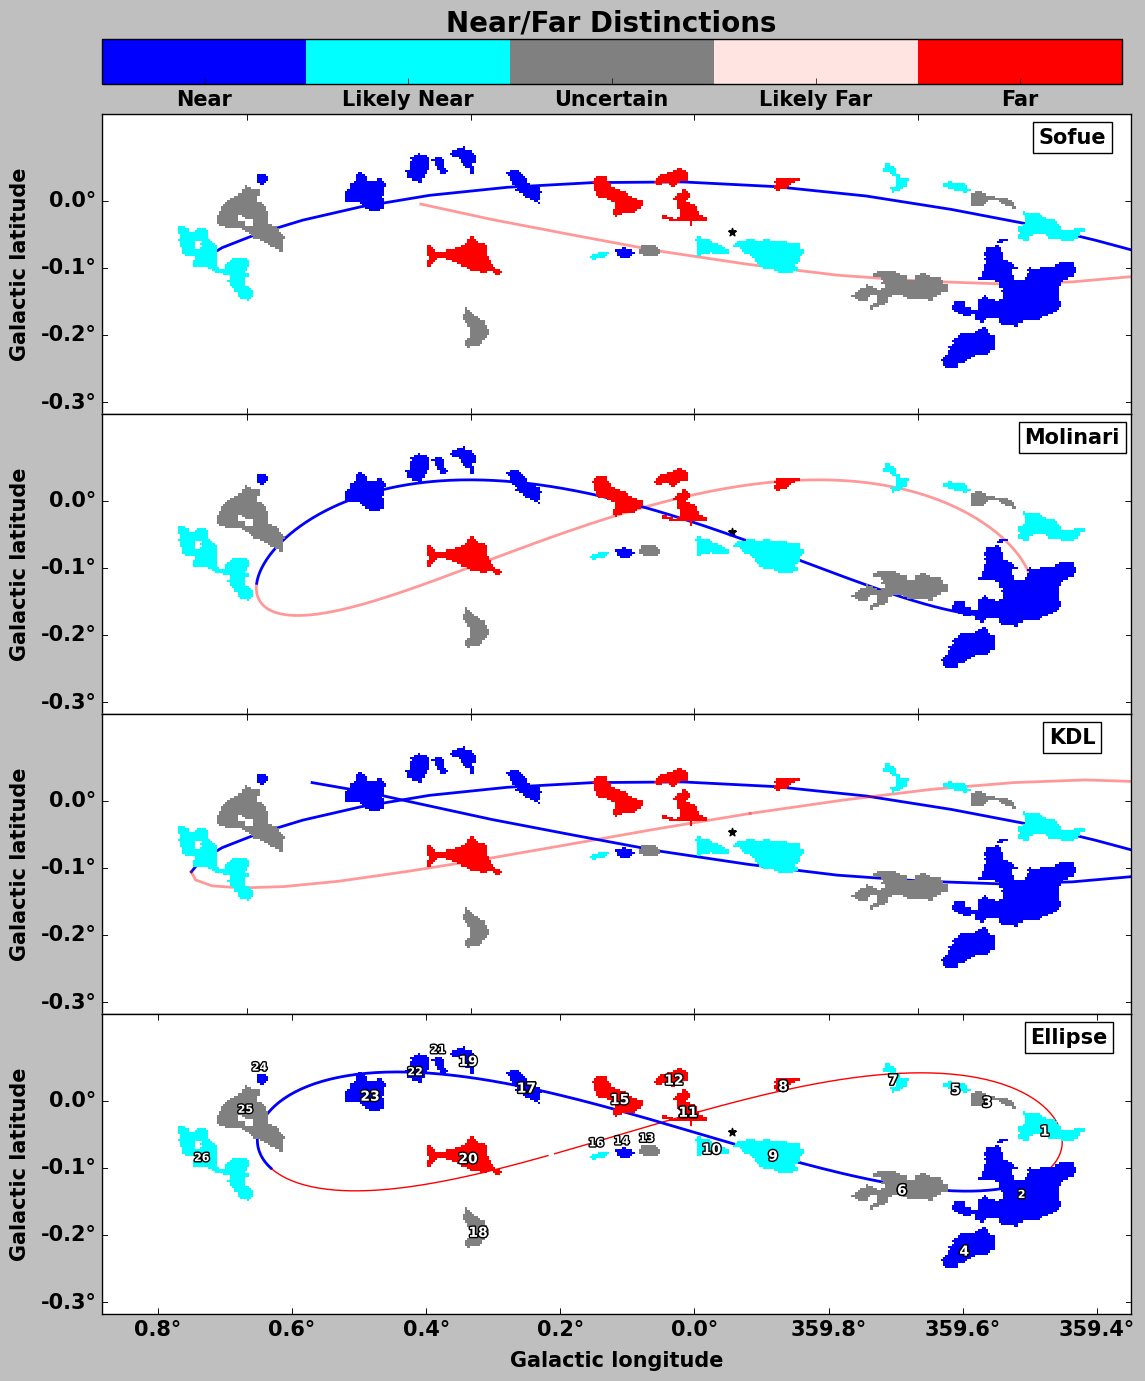

<Figure size 640x480 with 0 Axes>

In [405]:
####SINGLE COLUMN DUST EXTINCTION (RESIZED)####
####MEGA LB PLOT####
from mpdaf.obj import dms2deg

###Import the qualitative map
full_id_mask_qual = fits.open('../FITS/id_mask_mosaic_qualitative.fits')[0]
id_mask_qual_wcs = wcs.WCS(full_id_mask_qual.header)

NFU = cat_agg['NF_decision']

color_list = ['blue', 'cyan', 'gray' ,'mistyrose', 'red']
cmap = (mpl.colors.ListedColormap(color_list))

bounds=[1,2,3,4,5,6]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

l   = scouse_fits['l'].values
b   = scouse_fits['b'].values
v   = scouse_fits['velocity'].values
amp = scouse_fits['amp'].values




fig, ax = plt.subplots(nrows=4, ncols=1, subplot_kw={'projection': id_mask_qual_wcs},  figsize=(20,15), dpi=100, sharex = True, sharey=True)
plt.subplots_adjust(wspace=0, hspace=0)


for row in ax:
    clouds = row.imshow(full_id_mask_qual.data,interpolation='nearest', origin='lower', cmap=cmap, norm=norm, zorder=9)  
    #row.contourf(full_id_contours,  levels=np.arange(1,6,1), cmap=cmap, zorder=10)
    
        
    #row.grid(True)
    row.set_xlim(250,730)
    #row.set_ylim(-0.25,0.1)
    #row.set_rasterized(True)



"""
#Sofue
"""
sofue1 = np.loadtxt('sofue_lbv_arm1.txt', unpack=True)
sofue1_l, sofue1_b, sofue1_v = sofue1[0], sofue1[1], sofue1[2]
ax[0].plot(sofue1_l, sofue1_b, ls='-', color='blue', linewidth=2, zorder=2, transform=ax[0].get_transform('world'))

sofue2 = np.loadtxt('sofue_lbv_arm2.txt', unpack=True)
sofue2_l, sofue2_b, sofue2_v = sofue2[0], sofue2[1], sofue2[2]
ax[0].plot(sofue2_l, sofue2_b, ls='-', color='red', linewidth=2, zorder=2, alpha=0.4, transform=ax[0].get_transform('world'))
ax[0].xaxis.set_ticklabels([])
ax[0].yaxis.set_ticklabels([-.30," " , -0.20," " , -.10," " , 0.00," " , " "])
ax[0].text(0.943, 0.92,'Sofue', ha='center', va='center', transform=ax[0].transAxes,
           bbox=dict(facecolor='white', edgecolor='k', alpha=1))
ax[0].set_ylabel('Galactic latitude')

lat = ax[0].coords['glat']
lat_dms = Angle([-.30 , -0.20, -.10 , 0.00] * u.degree)
lat.set_ticks(lat_dms)
lat.set_major_formatter('d.d')

"""


#Molinari
"""
ml = np.loadtxt('molinari_lbvlos.txt', unpack=True)
lk, bk, vk = ml[0], ml[1], ml[2]
ax[1].plot(-1*lk[80:580], bk[80:580], ls='-', color='red', linewidth=2, zorder=2, alpha=0.4, transform=ax[1].get_transform('world'))
ax[1].plot(-1*lk[0:80], bk[0:80], ls='-', color='blue', linewidth=2, zorder=2, transform=ax[1].get_transform('world'))
ax[1].plot(-1*lk[581:], bk[581:], ls='-', color='blue', linewidth=2, zorder=2, transform=ax[1].get_transform('world'))
ax[1].text(0.943, 0.92,'Molinari', ha='center', va='center', transform=ax[1].transAxes,
           bbox=dict(facecolor='white', edgecolor='k', alpha=1))

ax[1].xaxis.set_ticklabels([])
ax[1].yaxis.set_ticklabels([-.30," " , -0.20," " , -.10," " , 0.00," " , " "])
ax[1].set_ylabel('Galactic latitude')
lat = ax[1].coords['glat']
lat_dms = Angle([-.30 , -0.20, -.10 , 0.00] * u.degree)
lat.set_ticks(lat_dms)
lat.set_major_formatter('d.d')


"""
#KDL
"""
kdl = np.loadtxt('kdl_lbv.txt', unpack=True)
lk, bk, vk = kdl[0], kdl[1], kdl[2]
ax[2].plot(lk[0:16], bk[0:16], ls='-', color='blue', linewidth=2, zorder=2, transform=ax[2].get_transform('world'))
ax[2].plot(lk[15:26], bk[15:26], ls='-', color='red', linewidth=2, zorder=2, alpha=0.4, transform=ax[2].get_transform('world'))
ax[2].plot(lk[25:36], bk[25:36], ls='-', color='red', linewidth=2, zorder=2, alpha=0.4, transform=ax[2].get_transform('world'))
ax[2].plot(lk[35:51], bk[35:51], ls='-', color='blue', linewidth=2, zorder=2, transform=ax[2].get_transform('world'))
ax[2].xaxis.set_ticklabels([])
ax[2].yaxis.set_ticklabels([-.30," " , -0.20," " , -.10," " , 0.00," " , " "])

ax[2].text(0.943, 0.92,'KDL', ha='center', va='center', transform=ax[2].transAxes,
           bbox=dict(facecolor='white', edgecolor='k', alpha=1))

ax[2].set_ylabel('Galactic latitude')
lat = ax[2].coords['glat']
lat_dms = Angle([-.30 , -0.20, -.10 , 0.00] * u.degree)
lat.set_ticks(lat_dms)
lat.set_major_formatter('d.d')

"""
#Rings
"""

#ax[3].imshow(full_id_mask_qual.data,interpolation='nearest', origin='lower', cmap=cmap, norm=norm, zorder=1) 


ax[3].plot(np.degrees(Rings.l[back_ind[0:-1]]),np.degrees(Rings.b[back_ind[0:-1]]),c='red',transform=ax[3].get_transform('world'))
ax[3].plot(np.degrees(Rings.l[fore_ind[0:]]),np.degrees(Rings.b[fore_ind[0:]]),c='blue', linewidth=2, zorder=2,transform=ax[3].get_transform('world'))

ax[3].yaxis.set_ticklabels([-.30," " , -0.20," " , -.10," " , 0.00," " , " "])
ax[3].text(0.94, 0.92,'Ellipse', ha='center', va='center', transform=ax[3].transAxes,
           bbox=dict(facecolor='white', edgecolor='k', alpha=1))



ax[3].set_xlabel('Galactic longitude')
ax[3].set_ylabel('Galactic latitude')

lon = ax[3].coords['glon']
lat = ax[3].coords['glat']
lon_dms=Angle([-0.6,-0.4,-0.2,0.0,0.2,0.4,0.6,0.8] * u.degree)
lon.set_ticks(lon_dms)
lon.set_major_formatter('d.d')


lat_dms = Angle([-.30 , -0.20, -.10 , 0.00] * u.degree)
lat.set_ticks(lat_dms)
lat.set_major_formatter('d.d')



text_list=[]
text_color = 'w'
for i in range(len(leaf_id_num)):
    anot_id=ax[3].text(id_l[i]+0.01, id_b[i]-0.008,s=leaf_id_num[i],color=text_color, fontsize=10, weight='bold',
                                path_effects=[PathEffects.withStroke(linewidth=2, foreground="black")], zorder=10,transform=ax[3].get_transform('world'))
    text_list.append(anot_id)

for i in range(38,len(leaf_id_num)):
    text_list[i].remove()


i=1 #ID 2
text_list[i].remove()
text_list[i]=ax[3].text(id_l[i]+0.01, id_b[i]-0.01,s=leaf_id_num[i],color=text_color, fontsize=8, 
                        weight='bold',path_effects=[PathEffects.withStroke(linewidth=2, foreground="black")], zorder=10, transform=ax[3].get_transform('galactic'))


i=19 #ID 13
text_list[i].remove()
text_list[i]=ax[3].text(id_l[i]+0.015, id_b[i]+0.015,s=leaf_id_num[i],color=text_color, fontsize=8, 
                        weight='bold',path_effects=[PathEffects.withStroke(linewidth=2, foreground="black")], transform=ax[3].get_transform('galactic'))

    
i=20 #ID 14
text_list[i].remove()
text_list[i]=ax[3].text(id_l[i]+0.015, id_b[i]+0.015,s=leaf_id_num[i],color=text_color, fontsize=8, 
                        weight='bold',path_effects=[PathEffects.withStroke(linewidth=2, foreground="black")], transform=ax[3].get_transform('galactic'))
                 
i=22 #ID 16
text_list[22].remove()
text_list[23].remove()
text_list[i]=ax[3].text(id_l[i]+0.015, id_b[i]+0.015,s=leaf_id_num[i],color=text_color, fontsize=8, 
                        weight='bold',path_effects=[PathEffects.withStroke(linewidth=2, foreground="black")], transform=ax[3].get_transform('galactic'))
    
i=30 #ID 21
text_list[30].remove()
text_list[31].remove()
text_list[i]=ax[3].text(id_l[i]+0.015, id_b[i]+0.021,s=leaf_id_num[i],color=text_color, fontsize=8, 
                        weight='bold',path_effects=[PathEffects.withStroke(linewidth=2, foreground="black")], transform=ax[3].get_transform('galactic'))

i=32 #ID 22
text_list[i].remove()
text_list[i]=ax[3].text(id_l[i]+0.015, id_b[i]-0.01,s=leaf_id_num[i],color=text_color, fontsize=8, 
                        weight='bold',path_effects=[PathEffects.withStroke(linewidth=2, foreground="black")], zorder=10, transform=ax[3].get_transform('galactic'))
         
i=34 #ID 24
text_list[i].remove()
text_list[i]=ax[3].text(id_l[i]+0.015, id_b[i]+0.015,s=leaf_id_num[i],color=text_color, fontsize=8, 
                        weight='bold',path_effects=[PathEffects.withStroke(linewidth=2, foreground="black")], transform=ax[3].get_transform('galactic'))
           
i=35 #ID 25
text_list[i].remove()
text_list[i]=ax[3].text(id_l[i]+0.015, id_b[i]+0.01,s=leaf_id_num[i],color=text_color, fontsize=8, 
                        weight='bold',path_effects=[PathEffects.withStroke(linewidth=2, foreground="black")], zorder=10, transform=ax[3].get_transform('galactic'))
            
    
i=36 #ID 26
text_list[i].remove()
text_list[37].remove()
text_list[i]=ax[3].text(id_l[i]+0.03, id_b[i],s=leaf_id_num[i],color=text_color, fontsize=8, 
                        weight='bold',path_effects=[PathEffects.withStroke(linewidth=2, foreground="black")], zorder=10, transform=ax[3].get_transform('galactic'))
              



ax[0].scatter(-0.056, -0.046, marker = "*", s=35, color='k', transform=ax[0].get_transform('world'))
ax[1].scatter(-0.056, -0.046, marker = "*", s=35, color='k', transform=ax[1].get_transform('world'))
ax[2].scatter(-0.056, -0.046, marker = "*", s=35, color='k', transform=ax[2].get_transform('world'))
ax[3].scatter(-0.056, -0.046, marker = "*", s=35, color='k', transform=ax[3].get_transform('world'))

cax = fig.add_axes([0.255, .92, 0.51, 0.03])


bounds = [1, 2, 3, 4, 5, 6]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb = fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=[1.5,2.5,3.5,4.5,5.5],
    spacing='proportional',
    orientation='horizontal',
    #label='Discrete intervals, some other units',
)

cb.ax.set_xticklabels(['Near', 'Likely Near', 'Uncertain', 'Likely Far', 'Far'])


#cb = plt.colorbar(sc, ax=ax.ravel().tolist(), orientation='horizontal', cax=cax)
cb.ax.set_title('Near/Far Distinctions', size=20, fontweight='bold', fontname='sans-serif')

plt.savefig('../paper_figs/Figs/onecol_3d_models_lb_ellipse_colorbar_MEGAPLOT.pdf', bbox_inches='tight')
plt.savefig('../paper_figs/Figs/onecol_3d_models_lb_ellipse_colorbar_MEGAPLOT.png', bbox_inches='tight')
plt.show()


plt.clf()

# MEGAPLOT WITHOUT ABSORPTION DATA

In [244]:
cat = Table.read('CMZ_cloud_catalogue_data_no_absorp.tex')

#find mean of a


cat_index = cat['index']
cat_v = cat['v']

r_p_mom0 = cat['r_p_mom0']
r_s_mom0 =cat['r_s_mom0']
r_p_max = cat['r_p_max']
r_s_max = cat['r_s_max']

corr_coeff_use = r_p_max 

cat.pprint_all()

index   cloud_name     l      b     v   sigma rad absorp r_p_mom0 r_s_mom0 r_p_max r_s_max flux_diff_mom0 flux_ratio_mom0 I_cloud_max I_model_max flux_diff_max flux_ratio_max ext_frac_max lb_pixel_mask NF_decision min_flux_max
----- -------------- ------ ------ ---- ----- --- ------ -------- -------- ------- ------- -------------- --------------- ----------- ----------- ------------- -------------- ------------ ------------- ----------- ------------
    1 G359.475-0.044 -0.525 -0.044 -102     6 4.3      3    0.261    0.444   0.261   0.444         31.669           0.506     212.667     317.106        31.669          0.506        0.992             1          LN       82.971
    2 G359.508-0.135 -0.492 -0.135  -56     9 8.7      3    0.384    0.397   0.384   0.397        -20.608           0.623     224.209     276.371       -20.608          0.623        0.815             1           N      117.934
    3 G359.561-0.001 -0.439 -0.001  -90     8 2.7      0    0.222    0.325   0.222   0.325  

In [245]:
cat_group = cat.group_by('lb_pixel_mask')
cat_group_mask = cat_group.groups.keys['lb_pixel_mask'] == 1

cat_agg = cat_group.groups[cat_group_mask]
cat_agg.pprint_all()

index   cloud_name     l      b     v   sigma rad absorp r_p_mom0 r_s_mom0 r_p_max r_s_max flux_diff_mom0 flux_ratio_mom0 I_cloud_max I_model_max flux_diff_max flux_ratio_max ext_frac_max lb_pixel_mask NF_decision min_flux_max
----- -------------- ------ ------ ---- ----- --- ------ -------- -------- ------- ------- -------------- --------------- ----------- ----------- ------------- -------------- ------------ ------------- ----------- ------------
    1 G359.475-0.044 -0.525 -0.044 -102     6 4.3      3    0.261    0.444   0.261   0.444         31.669           0.506     212.667     317.106        31.669          0.506        0.992             1          LN       82.971
    2 G359.508-0.135 -0.492 -0.135  -56     9 8.7      3    0.384    0.397   0.384   0.397        -20.608           0.623     224.209     276.371       -20.608          0.623        0.815             1           N      117.934
    3 G359.561-0.001 -0.439 -0.001  -90     8 2.7      0    0.222    0.325   0.222   0.325  

22.999999999999996
1.0
1.0


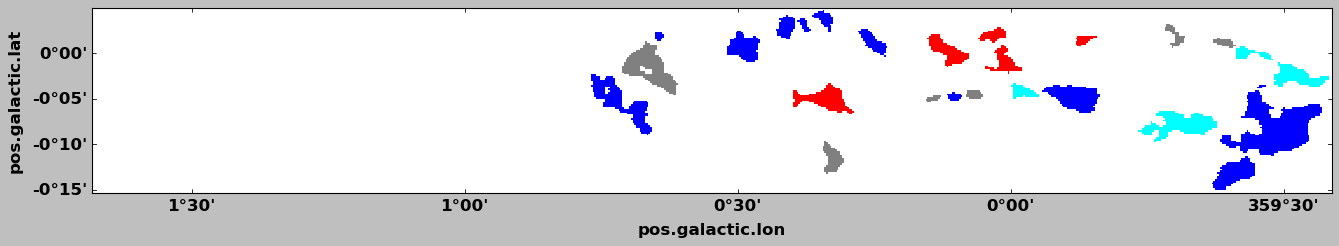

In [246]:
from astropy import wcs
import copy

full_id_mask = fits.open('../FITS/id_mask_mosaic.fits')[0]
id_mask_wcs = wcs.WCS(full_id_mask.header)

full_id_contours = copy.deepcopy(full_id_mask.data)
full_id_contours[np.where(np.isnan(full_id_mask.data) == True)] = 0
full_id_contours[np.where(full_id_mask.data>=27)] = 0


full_mosaic_cmapped = copy.deepcopy(full_id_mask.data)
full_mosaic_cmapped[np.where(np.isnan(full_id_mask.data) == True)] = np.nan
full_mosaic_cmapped[np.where(full_id_mask.data>=27)] = np.nan

#full_mosaic_cmapped = np.empty_like(full_id_mask.data)
#full_mosaic_cmapped.fill(np.nan)

N_ind = np.where(cat_agg['NF_decision']=='N')
LN_ind = np.where(cat_agg['NF_decision']=='LN')
U_ind = np.where(cat_agg['NF_decision']=='U')
LF_ind = np.where(cat_agg['NF_decision']=='LF')
F_ind = np.where(cat_agg['NF_decision']=='F')
non_ind = np.where(cat_agg['NF_decision']=='nan')



for i in N_ind[0]:
    full_mosaic_cmapped[np.round(full_id_mask.data) ==i+1] = 1
    full_id_contours[np.round(full_id_mask.data) ==i+1] = 1
for i in LN_ind[0]:
    full_mosaic_cmapped[np.round(full_id_mask.data) ==i+1] = 2
    full_id_contours[np.round(full_id_mask.data) ==i+1] = 2
    
for i in U_ind[0]:
    full_mosaic_cmapped[np.round(full_id_mask.data) ==i+1] = 3
    full_id_contours[np.round(full_id_mask.data) ==i+1] = 3
    
for i in LF_ind[0]:
    full_mosaic_cmapped[np.round(full_id_mask.data) ==i+1] = 4
    full_id_contours[np.round(full_id_mask.data) ==i+1] = 4
    
for i in F_ind[0]:
    full_mosaic_cmapped[np.round(full_id_mask.data) ==i+1] = 5
    full_id_contours[np.round(full_id_mask.data) ==i+1] = 5
    
     
    
    
    
fits.writeto('../FITS/id_mask_mosaic_qualitative_no_absorp.fits', full_mosaic_cmapped, full_id_mask.header, overwrite=True)
fits.writeto('../FITS/id_mask_mosaic_zeros_no_absorp.fits', full_id_contours, full_id_mask.header, overwrite=True)


color_list = ['blue', 'cyan', 'gray' ,'mistyrose', 'red']
cmap = (mpl.colors.ListedColormap(color_list))

bounds=[1,2,3,4,5,6]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection': id_mask_wcs},  figsize=(20,8))
ax.imshow(full_mosaic_cmapped,interpolation='nearest', origin='lower', cmap=cmap, norm=norm)  


#ax.contour(full_id_contours, levels=[0,1], colors='black')

#ax.contourf(full_id_mask.data==22, levels=np.arange(0.5,27,0.5), colors='green')


print(full_id_mask.data[80][368])
print(full_mosaic_cmapped[80][368])

print(full_id_contours[80][368])

/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_5030/2959991918.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].yaxis.set_ticklabels([-.30," " , -0.20," " , -.10," " , 0.00," " , " "])
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_5030/2959991918.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].yaxis.set_ticklabels([-.30," " , -0.20," " , -.10," " , 0.00," " , " "])


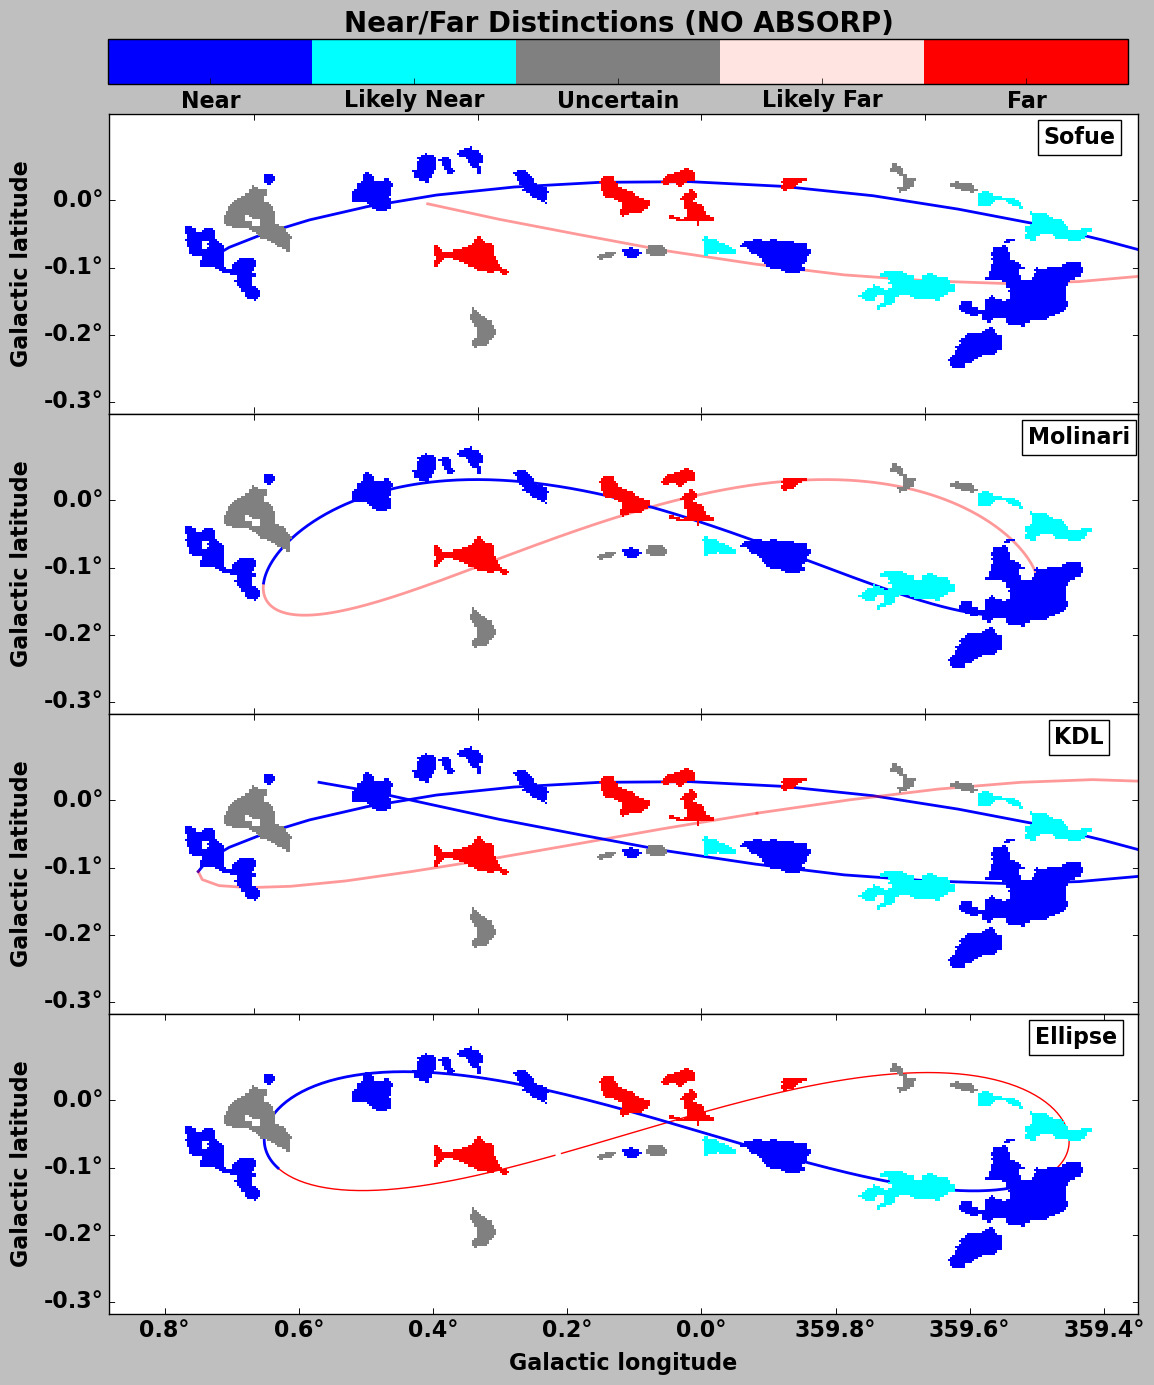

<Figure size 640x480 with 0 Axes>

In [356]:
####SINGLE COLUMN DUST EXTINCTION (RESIZED)####
####MEGA LB PLOT####
from mpdaf.obj import dms2deg

###Import the qualitative map
full_id_mask_qual = fits.open('../FITS/id_mask_mosaic_qualitative_no_absorp.fits')[0]
id_mask_qual_wcs = wcs.WCS(full_id_mask_qual.header)

NFU = cat_agg['NF_decision']

color_list = ['blue', 'cyan', 'gray' ,'mistyrose', 'red']
cmap = (mpl.colors.ListedColormap(color_list))

bounds=[1,2,3,4,5,6]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

l   = scouse_fits['l'].values
b   = scouse_fits['b'].values
v   = scouse_fits['velocity'].values
amp = scouse_fits['amp'].values




fig, ax = plt.subplots(nrows=4, ncols=1, subplot_kw={'projection': id_mask_qual_wcs},  figsize=(20,15), dpi=100, sharex = True, sharey=True)
plt.subplots_adjust(wspace=0, hspace=0)


for row in ax:
    clouds = row.imshow(full_id_mask_qual.data,interpolation='nearest', origin='lower', cmap=cmap, norm=norm, zorder=9)  
    #row.contourf(full_id_contours,  levels=np.arange(1,6,1), cmap=cmap, zorder=10)
    
        
    #row.grid(True)
    row.set_xlim(250,730)
    #row.set_ylim(-0.25,0.1)
    #row.set_rasterized(True)



"""
#Sofue
"""
sofue1 = np.loadtxt('sofue_lbv_arm1.txt', unpack=True)
sofue1_l, sofue1_b, sofue1_v = sofue1[0], sofue1[1], sofue1[2]
ax[0].plot(sofue1_l, sofue1_b, ls='-', color='blue', linewidth=2, zorder=2, transform=ax[0].get_transform('world'))

sofue2 = np.loadtxt('sofue_lbv_arm2.txt', unpack=True)
sofue2_l, sofue2_b, sofue2_v = sofue2[0], sofue2[1], sofue2[2]
ax[0].plot(sofue2_l, sofue2_b, ls='-', color='red', linewidth=2, zorder=2, alpha=0.4, transform=ax[0].get_transform('world'))
ax[0].xaxis.set_ticklabels([])
ax[0].yaxis.set_ticklabels([-.30," " , -0.20," " , -.10," " , 0.00," " , " "])
ax[0].text(0.943, 0.92,'Sofue', ha='center', va='center', transform=ax[0].transAxes,
           bbox=dict(facecolor='white', edgecolor='k', alpha=1))
ax[0].set_ylabel('Galactic latitude')

lat = ax[0].coords['glat']
lat_dms = Angle([-.30 , -0.20, -.10 , 0.00] * u.degree)
lat.set_ticks(lat_dms)
lat.set_major_formatter('d.d')

"""


#Molinari
"""
ml = np.loadtxt('molinari_lbvlos.txt', unpack=True)
lk, bk, vk = ml[0], ml[1], ml[2]
ax[1].plot(-1*lk[80:580], bk[80:580], ls='-', color='red', linewidth=2, zorder=2, alpha=0.4, transform=ax[1].get_transform('world'))
ax[1].plot(-1*lk[0:80], bk[0:80], ls='-', color='blue', linewidth=2, zorder=2, transform=ax[1].get_transform('world'))
ax[1].plot(-1*lk[581:], bk[581:], ls='-', color='blue', linewidth=2, zorder=2, transform=ax[1].get_transform('world'))
ax[1].text(0.943, 0.92,'Molinari', ha='center', va='center', transform=ax[1].transAxes,
           bbox=dict(facecolor='white', edgecolor='k', alpha=1))

ax[1].xaxis.set_ticklabels([])
ax[1].yaxis.set_ticklabels([-.30," " , -0.20," " , -.10," " , 0.00," " , " "])
ax[1].set_ylabel('Galactic latitude')
lat = ax[1].coords['glat']
lat_dms = Angle([-.30 , -0.20, -.10 , 0.00] * u.degree)
lat.set_ticks(lat_dms)
lat.set_major_formatter('d.d')



"""
#KDL
"""
kdl = np.loadtxt('kdl_lbv.txt', unpack=True)
lk, bk, vk = kdl[0], kdl[1], kdl[2]
ax[2].plot(lk[0:16], bk[0:16], ls='-', color='blue', linewidth=2, zorder=2, transform=ax[2].get_transform('world'))
ax[2].plot(lk[15:26], bk[15:26], ls='-', color='red', linewidth=2, zorder=2, alpha=0.4, transform=ax[2].get_transform('world'))
ax[2].plot(lk[25:36], bk[25:36], ls='-', color='red', linewidth=2, zorder=2, alpha=0.4, transform=ax[2].get_transform('world'))
ax[2].plot(lk[35:51], bk[35:51], ls='-', color='blue', linewidth=2, zorder=2, transform=ax[2].get_transform('world'))
ax[2].xaxis.set_ticklabels([])


ax[2].text(0.943, 0.92,'KDL', ha='center', va='center', transform=ax[2].transAxes,
           bbox=dict(facecolor='white', edgecolor='k', alpha=1))

ax[2].set_ylabel('Galactic latitude')


lat = ax[2].coords['glat']
lat_dms = Angle([-.30 , -0.20, -.10 , 0.00] * u.degree)
lat.set_ticks(lat_dms)
lat.set_major_formatter('d.d')

"""
#Rings
"""

#ax[3].imshow(full_id_mask_qual.data,interpolation='nearest', origin='lower', cmap=cmap, norm=norm, zorder=1) 

ax[3].plot(np.degrees(Rings.l[back_ind[0:-1]]),np.degrees(Rings.b[back_ind[0:-1]]),c='red',transform=ax[3].get_transform('world'))
ax[3].plot(np.degrees(Rings.l[fore_ind[0:]]),np.degrees(Rings.b[fore_ind[0:]]),c='blue', linewidth=2, zorder=2,transform=ax[3].get_transform('world'))

#ax[3].yaxis.set_ticklabels([-.30," " , -0.20," " , -.10," " , 0.00," " , " "])
ax[3].text(0.94, 0.92,'Ellipse', ha='center', va='center', transform=ax[3].transAxes,
           bbox=dict(facecolor='white', edgecolor='k', alpha=1))



ax[3].set_xlabel('Galactic longitude')
ax[3].set_ylabel('Galactic latitude')

lon = ax[3].coords['glon']
lat = ax[3].coords['glat']
lon_dms=Angle([-0.6,-0.4,-0.2,0.0,0.2,0.4,0.6,0.8] * u.degree)
lon.set_ticks(lon_dms)
lon.set_major_formatter('d.d')


lat_dms = Angle([-.30 , -0.20, -.10 , 0.00] * u.degree)
lat.set_ticks(lat_dms)
lat.set_major_formatter('d.d')








cax = fig.add_axes([0.255, .92, 0.51, 0.03])


bounds = [1, 2, 3, 4, 5, 6]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb = fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=[1.5,2.5,3.5,4.5,5.5],
    spacing='proportional',
    orientation='horizontal',
    #label='Discrete intervals, some other units',
)

cb.ax.set_xticklabels(['Near', 'Likely Near', 'Uncertain', 'Likely Far', 'Far'])


#cb = plt.colorbar(sc, ax=ax.ravel().tolist(), orientation='horizontal', cax=cax)
cb.ax.set_title('Near/Far Distinctions (NO ABSORP)', size=20, fontweight='bold', fontname='sans-serif')

plt.savefig('../paper_figs/Figs/onecol_3d_models_lb_ellipse_colorbar_MEGAPLOT_NO_ABSORPTION.pdf', bbox_inches='tight')
plt.savefig('../paper_figs/Figs/onecol_3d_models_lb_ellipse_colorbar_MEGAPLOT_NO_ABSORPTION.png', bbox_inches='tight')

plt.show()


plt.clf()

In [317]:
ticks_dm = Angle([-0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6]*u.deg)
ticks_dms = ticks_dec.wrap_at(360 * u.deg)

<Angle [-0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6] deg>

In [314]:
ticks_dec = Angle([-0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6]*u.deg)
ticks_dms

<Angle [3.594e+02, 3.596e+02, 3.598e+02, 0.000e+00, 2.000e-01, 4.000e-01,
        6.000e-01] deg>

In [345]:
dms.degree

array([-0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8])

Text(0.5, 0, '')